### Objective


In [1]:
!pip install sklearn
!pip install seaborn

Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable


In [5]:
import asyncio
from collections import defaultdict
from itertools import islice
import math
import random
import os

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from scipy import interpolate
from scipy.spatial.distance import euclidean
from sklearn.cluster import KMeans

from binance import Client, AsyncClient
from stockstats import wrap, unwrap

pd.options.mode.chained_assignment = None  # default='warn'


In [3]:
# Get environment variables
api_key = os.getenv('BINANCE_KEY')
api_secret = os.environ.get('BINANCE_SECRET')

client = AsyncClient(api_key, api_secret)

await client.create()

### Getting actively trading symbols



In [6]:
exchange_info = await client.get_exchange_info()
symbols = exchange_info["symbols"]
excluded_symbols = ['BUSD', 'USDC', 'EUR', 'DAI', 'AUD']

usdt_symbols = list(
    filter(lambda x: x["status"] == "TRADING" and 
                     x["quoteAsset"] == "USDT" and
                     x["baseAsset"] not in excluded_symbols, 
           symbols)
)



NameError: name 'client' is not defined

### Fetch prices off all active symbols

In [6]:
def chunked_iterable(iterable, chunk_size):
    it = iter(iterable)
    while True:
        chunk = list(islice(it, chunk_size))
        if not chunk:
            break
        yield chunk
        
def preprocess_price_data(price_data_raw, base_asset):
    price_data = pd.DataFrame(price_data_raw,
                               dtype='float',
                               columns=['open_time', 'open', 'high', 'low', 'close', 'volume', 
                                        'close_time', 'quote_volume', 'trade_count', 'taker_buy_vol', 
                                        'taker_buy_quote_vol', 'unused'])
    price_data['time'] = pd.to_datetime(price_data['open_time'], unit='ms')


    price_data.drop(columns=['open_time', 'close_time', 'taker_buy_vol', 
                              'taker_buy_quote_vol', 'volume', 'trade_count', 'unused'], 
                 inplace= True) # drop the unnecessary columns.

    price_data.rename(columns={'quote_volume':'volume'}, inplace=True)
    price_data[['symbol']] = base_asset
    price_data.set_index('time', inplace=True)
    
    return price_data

async def fetch_symbol(symbol, period, start, end=None):
    price_data_raw = await client.get_historical_klines(symbol['symbol'], period, start, end)
    return preprocess_price_data(price_data_raw, symbol['baseAsset'])

async def fetch_chunk(symbol_chunk, period, start, end=None):
    tasks = []
    for symbol in symbol_chunk:
        task = asyncio.ensure_future(fetch_symbol(symbol, period, start, end))
        tasks.append(task)
    return await asyncio.gather(*tasks, return_exceptions=False)

In [9]:
MAX_WORKERS = 40
symbol_prices = []
start = "36 day ago UTC"
end = None #"100 day ago UTC"

for index, symbols_in_chunk in enumerate(chunked_iterable(usdt_symbols, MAX_WORKERS)):
    chunk_results = await fetch_chunk(symbols_in_chunk, Client.KLINE_INTERVAL_1HOUR, start, end)
    symbol_prices.extend(chunk_results)
    
market_prices_online = pd.concat(symbol_prices)

start, end = market_prices_online.index[0], market_prices_online.index[-1]
ref_time = pd.date_range(start, end, freq='1H')

market_prices_online = market_prices_online.groupby('symbol').filter(lambda x: len(x) == len(ref_time))

market_prices_online.to_csv('market_prices.csv')


### After price fetching

In [7]:
market_prices_raw = pd.read_csv('market_prices.csv', parse_dates=['time'], index_col='time')
market_prices_raw[market_prices_raw.symbol=='BTC'].tail()


open      high       low     close        volume  \
time                                                                        
2022-11-06 04:00:00  21234.44  21252.54  21212.99  21227.73  1.131489e+08   
2022-11-06 05:00:00  21228.62  21240.95  21143.27  21155.41  1.767493e+08   
2022-11-06 06:00:00  21154.86  21191.17  21144.92  21171.47  1.484046e+08   
2022-11-06 07:00:00  21171.47  21206.00  21157.23  21194.49  1.660746e+08   
2022-11-06 08:00:00  21193.88  21214.52  21173.03  21195.18  5.019551e+07   

                    symbol  
time                        
2022-11-06 04:00:00    BTC  
2022-11-06 05:00:00    BTC  
2022-11-06 06:00:00    BTC  
2022-11-06 07:00:00    BTC  
2022-11-06 08:00:00    BTC

In [8]:
def post_process(price_df, features, N):
    ts_df = wrap(price_df)
    df = unwrap(ts_df)

    df[features] = ts_df[features]  # calculate features
    df = df.tail(df.shape[0] - N) # remove first N rows. because ema filter values are not fully correct in first rows
    df[features] = ts_df[features] / df['close'][0]  # normalize all features wrt to close
    df['close'] = df['close'] / df['close'][0]  # normalize close as well. order is important!

    return df

In [9]:
features = ['close_100_ema', 
           'close_50_ema', 
           'close_25_ema', 
           'close_3_ema']

N = 280

market_prices = market_prices_raw. \
                    groupby('symbol', group_keys=False). \
                    apply(post_process, features, N)


In [10]:
market_prices.describe()

open          high           low          close        volume  \
count  1.938880e+05  1.938880e+05  1.938880e+05  193888.000000  1.938880e+05   
mean   1.081012e+02  1.085347e+02  1.076792e+02       1.049299  1.115365e+06   
std    1.181240e+03  1.185122e+03  1.177391e+03       0.176099  1.533355e+07   
min    7.500000e-07  7.500000e-07  7.300000e-07       0.459219  0.000000e+00   
25%    6.340000e-02  6.380750e-02  6.308750e-02       0.979849  1.573310e+04   
50%    3.970000e-01  4.000000e-01  3.940000e-01       1.018741  4.633232e+04   
75%    2.975000e+00  2.994850e+00  2.957000e+00       1.079030  1.652716e+05   
max    2.144519e+04  2.148065e+04  2.138153e+04       6.245684  1.527501e+09   

       close_100_ema   close_50_ema   close_25_ema    close_3_ema  
count  193888.000000  193888.000000  193888.000000  193888.000000  
mean        1.041099       1.043816       1.046284       1.049047  
std         0.144621       0.158485       0.166909       0.175152  
min         0.526301       0.494781       0.480987       0.462588  
25%         0.988599       0.984590       0.981611       0.979985  
50%         1.016542       1.015236       1.016043       1.018327  
75%         1.062435       1.069321       1.073766       1.078637  
max         4.045389       4.356108       4.652088       5.250035

In [11]:
market_prices.head()

open   high    low     close       volume symbol  \
time                                                                     
2022-10-13 01:00:00  0.568  0.569  0.562  1.000000   36209.4169  1INCH   
2022-10-13 02:00:00  0.563  0.563  0.555  0.996448  348039.5854  1INCH   
2022-10-13 03:00:00  0.560  0.564  0.559  1.000000   17513.8978  1INCH   
2022-10-13 04:00:00  0.562  0.563  0.559  0.996448   52567.2342  1INCH   
2022-10-13 05:00:00  0.559  0.560  0.556  0.991119   27631.1494  1INCH   

                     close_100_ema  close_50_ema  close_25_ema  close_3_ema  
time                                                                         
2022-10-13 01:00:00       1.026123      1.014851      1.009426     1.005310  
2022-10-13 02:00:00       1.025533      1.014130      1.008428     1.000879  
2022-10-13 03:00:00       1.025026      1.013576      1.007779     1.000439  
2022-10-13 04:00:00       1.024458      1.012904      1.006908     0.998444  
2022-10-13 05:00:00       1.023796      1.012050      1.005693     0.994781

## After post processing is finished

### Fitting EMA curves with BSpline

In [12]:
parameters = {
    'close_100_ema' : {
        'SR': 32,
        'PADDING':8,
        'ORDER': 3,
    },
    'close_50_ema' : {
        'SR': 24,
        'PADDING':4,
        'ORDER': 3,
    },
    'close_25_ema' : {
        'SR': 18,
        'PADDING':1,
        'ORDER':3,
    },
}

class BSplineFitter(object):
    time_axis = None
    x_axis = None
    coefficients = None
    knots = None
    
    def __init__(self, feature_tag):
        self._tag = feature_tag
        params = parameters[feature_tag]
        self._sr = params['SR'] # sampling rate for knot positions
        self._padding = params['PADDING'] # left, right padding in axis
        self._order = params['ORDER'] # order of piecewise polynimals 
        
    def _calculate_axis(self, market_prices):
        """
        generates the time_axis and x_axis to be used in fitting
        
        """
        self.time_axis = market_prices[market_prices['symbol']=='BTC'].index 
        self.x_axis = np.arange(0, len(self.time_axis))
        
    
    def _bspline_fit(self, price_df, fixed_knots):
        """
        core method for b-spline fitting.
        
        """
        knots, coefficients, order = interpolate.splrep(self.x_axis, price_df[self._tag], 
                                                        t=fixed_knots, k=self._order)
        
        return (knots.astype(int), coefficients, order)
    
    def fit(self, market_prices):
        """
        Fit function first calculates the knots positions with respect to 
        configuration settings. Then applies '_bspline_fit' method to every group 
        in the market_prices grouped by symbol names.
        
        |--+ inputs
           |-- market_prices: pd.DataFrame. consist whole market price data.
        
        """
        self._calculate_axis(market_prices)
        
        fixed_knots = np.arange(
            self._padding, len(self.x_axis) - self._padding, self._sr
        )
        
        _results = market_prices.groupby('symbol', group_keys=False).\
                                        apply(self._bspline_fit, fixed_knots )
        
        # grab knots and coefficients separately
        self.knots = _results[0][0] 
        self.coefficients = _results.apply(lambda x:x[1])
        
    def generate_curve(self, coefficients):
        """
        regenerates the curve from b-splines coefficients, knot positions 
        and order of the piecewise polynomials.
        
        |--+ inputs
            |-- coefficients: np.darray. bspline coefficients
        
        """
        curve = interpolate.BSpline(self.knots, coefficients, self._order)(self.x_axis)
        curve = pd.DataFrame.from_dict({'time': self.time_axis, 'values': curve})
        curve = curve.set_index('time')
        return curve


In [13]:
curve_fitter = BSplineFitter('close_100_ema')
curve_fitter.fit(market_prices)

curve_fitter.coefficients

symbol
1INCH    [1.0264308226681746, 1.0242240203694164, 1.012...
AAVE     [1.0430574022348391, 1.0413845468473084, 1.015...
ACA      [1.0526936523451937, 1.0431814053039232, 1.030...
ACH      [1.0222283701619268, 1.058251016888325, 0.9495...
ACM      [1.0776100007294933, 1.0718464194029085, 1.039...
                               ...                        
YGG      [1.0655404622772886, 1.0554716206374322, 1.035...
ZEC      [1.0298935374623215, 1.0264510254578307, 1.009...
ZEN      [1.0468337943411539, 1.0428239578270257, 1.019...
ZIL      [1.0265310130567675, 1.0234551261427944, 1.006...
ZRX      [1.038667529683574, 1.0353867503621588, 1.0140...
Length: 332, dtype: object

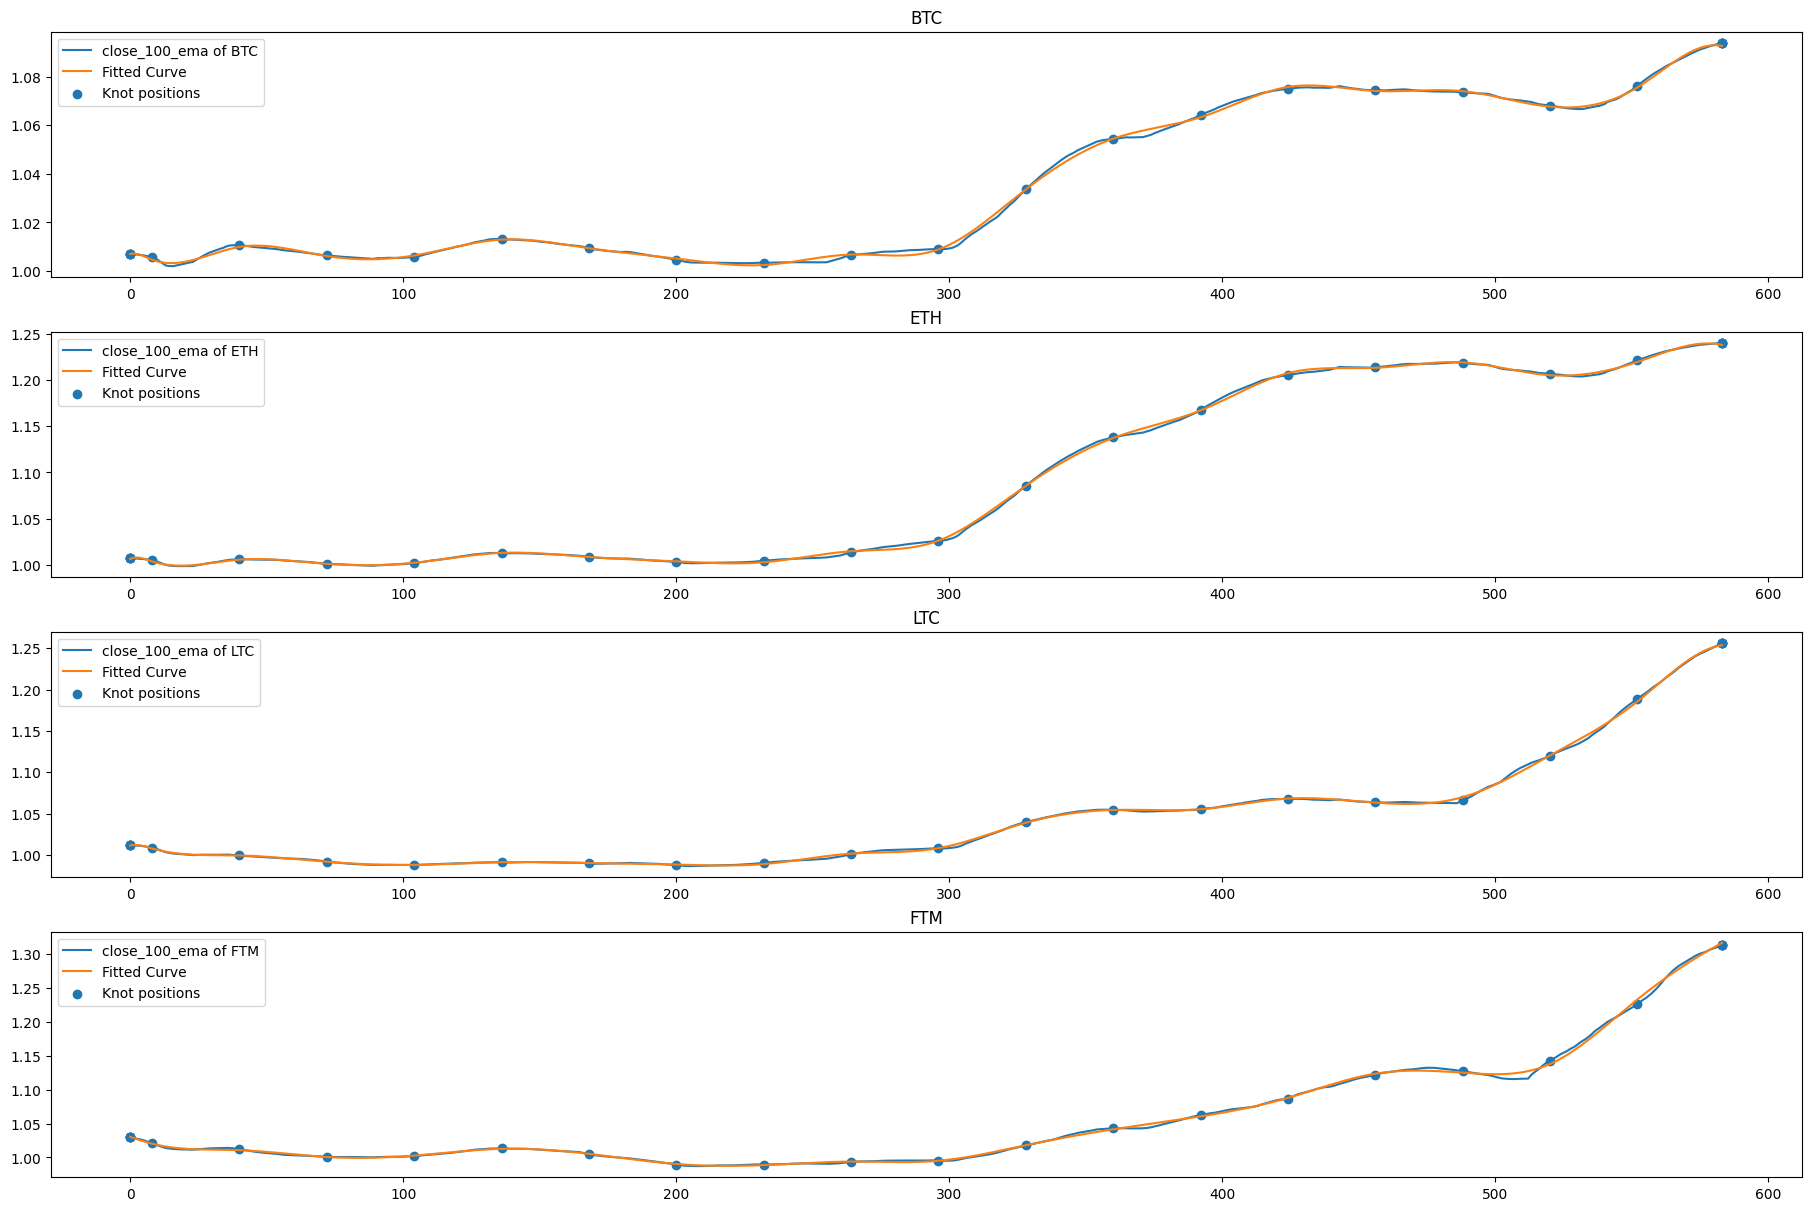

In [14]:
plt.rcParams['figure.figsize'] = [18, 12]
tag = curve_fitter._tag
symbols = ['BTC', 'ETH', 'LTC', 'FTM']
fig, axs = plt.subplots(len(symbols), 1, constrained_layout=True)
for index, symbol in enumerate(symbols):
    ax = axs[index]
    ax.set_title(symbol)
    coefficients = curve_fitter.coefficients[symbol]
    feature_vector = market_prices[market_prices.symbol==symbol][tag]
    fitted_curve = curve_fitter.generate_curve(coefficients)

    knots = curve_fitter.knots

    ax.plot(feature_vector.values, label=f'{tag} of {symbol}')
    ax.plot(fitted_curve.values, label='Fitted Curve')
    ax.scatter(knots, feature_vector.values[knots], label='Knot positions')
    ax.legend()
    


In [20]:
curve_fitters = {}

for feature_tag, config in parameters.items():
    curve_fitters[feature_tag] = BSplineFitter(feature_tag)
    curve_fitters[feature_tag].fit(market_prices)


## Clustering

In [839]:
def random_state():
    """
    utility function for generating random state
    """
    return random.randint(0, 1000)

In [16]:
class Cluster(object):
    """
    Cluster class to store cluster data.
    
    |--+ properties:
       |-- symbols: list of symbols included in the cluster.
       |-- center: b-spline coefficients of center of the cluster.
       |-- curve: re-generated curve from center coefficients.
       |-- errors: pd.Dataframe to store error of each symbol in 
                   the cluster wrt to curve
       |-- tag: feature tag is used to calculate the cluster.
                   e.g. close_50_ema, close_100_ema
       |-- label: label (id) of the cluster.
       
    
    """
    
    COLS = 4
    def __init__(self):
        self.symbols = None
        self.center = None 
        self.curve = None # re-generated curve from center coefficients
        self.errors = None # pd.Dataframe to store error of each symbol in the cluster wrt to curve
        self.tag = ''
        self.label = ''
    
    def __str__(self):
        return f'Cluster #{self.label} \nSymbols :{self.symbols}'
    
    def __repr__(self):
        return self.__str__()
    
    
    def calculate_error(self, market_prices):
        """
        calculates euclidean distance between center curve 
        for each symbol in the cluster

        |--+ prerequisites
           |-- .curve field must be set beforehand. 
           |-- .symbols field must be set beforehand.

        |--+ inputs:
           |-- market_prices: pandas.DataFrame. includes all the price data 
                            and features

        """
        
        assert self.curve is not None, "curve must not be None"
        assert self.symbols is not None, "symbols must not be None"
        
        def normalize(vector):
            return vector/np.linalg.norm(vector)
        
        def calculate_symbol_error(symbol):
            actual_feature = market_prices[market_prices.symbol==symbol][self.tag]
            error = euclidean(normalize(np.array(self.curve['values'])), 
                              normalize(np.array(actual_feature.values)))
            return error
        
        errors = self.symbols.apply(calculate_symbol_error).rename('error')
        self.errors = pd.concat([errors, self.symbols], axis=1)
        self.errors = self.errors.sort_values(by='error', ascending=True)
        
    
    def plot(self, market_prices, N=math.inf):
        """
        plots symbol prices in the cluster in a ascending order w.r.t 
        their error
        
        |--+ inputs
           |-- market_prices:  pd.DataFrame. market price data with whole
                        symbols available. It is used for visualization for 
                        symbol features.
           |-- N, integer [optional] : max number of symbols to plot.
        
        """
        features_to_plot = ['close_25_ema', 'close_100_ema']
        n_symbols_to_plot = min(len(self.symbols), N)
        
        row_count = int(math.ceil(n_symbols_to_plot / self.COLS))
        row_count = row_count + 1 if n_symbols_to_plot == ( row_count * self.COLS) else row_count
        fig, axis = plt.subplots(row_count, self.COLS)
        fig.tight_layout()
            
        # make axis array 2d again if it is 1d
        if axis.ndim == 1:
            axis = axis.reshape(1, -1)
            
        ax = axis[0, 0]
        ax.set_title(f'Center curve of cluster #{self.label}')
        self.curve.plot(ax=axis[0, 0], legend=None, color='#0000cc')
        fig.tight_layout()
        
        symbol_prices = market_prices.groupby('symbol')[features_to_plot]
        plt.rcParams['figure.figsize'] = [self.COLS * 6, row_count * 6]
        for row_index, row in enumerate(self.errors.itertuples(), start=1):
            ax = axis[int(row_index / self.COLS)][row_index % self.COLS]
            
            ax.set_title(f"Symbol : {row.symbol}, Error : {row.error:.4f}")
            symbol_prices.get_group(row.symbol).plot(ax=ax, color=['#0080ff','#0000cc'])
            

In [29]:
class ClusterFinder(object):
    COLS = 4

    def __init__(self, cluster_nr, curve_fitter):
        self._tag = curve_fitter._tag
        self._cluster_nr = cluster_nr
        self._curve_fitter = curve_fitter

        self.result = None
        self.clusters = defaultdict(Cluster)

    def fit(self, market_prices, symbols=None):
        """
        uses k-means algorithm to cluster symbols with respect to their
        b-spline coefficients.

        |--+ inputs
           |-- market_prices: pd.DataFrame. market price data with whole
                       symbols available. It is used for error calculation
                       after clustering operation is finished.

           |-- symbols: [optional] list or pd.Series. symbols to cluster.
                       if no symbols are provided it will cluster whole
                       symbols existed in the BSplineFitter.coefficients

        """
        if symbols is not None:
            coefficients = self._curve_fitter.coefficients[symbols]
        else:
            coefficients = self._curve_fitter.coefficients
            symbols = coefficients.index

        _kmeans = KMeans(
            init="k-means++",
            n_clusters=min(self._cluster_nr, len(symbols)),
            n_init=50,
            max_iter=300,
            random_state=42,
            tol = 1e-6
        )
        
        self.result = _kmeans.fit(np.array(coefficients.values.tolist()))
        
        symbols_in_clusters = pd.DataFrame.from_dict(
                                { 'cluster_id':self.result.labels_, 
                                  'symbol':symbols
                                })
        
        self.clusters = defaultdict(Cluster)
        for cluster_id, symbols_in_cluster in symbols_in_clusters.groupby('cluster_id'):
            self.clusters[cluster_id].symbols = symbols_in_cluster['symbol']
            self.clusters[cluster_id].tag = self._tag
            self.clusters[cluster_id].label = cluster_id
            self.clusters[cluster_id].center = self.result.cluster_centers_[cluster_id]
            self.clusters[cluster_id].curve = self._curve_fitter.generate_curve(
                self.clusters[cluster_id].center
            )
            
            self.clusters[cluster_id].calculate_error(market_prices)
        
        print(
            f"It took {self.result.n_iter_} of iterations to cluster into "
            f"{len(np.unique(self.result.labels_))} group."
            f"Inertia is : {self.result.inertia_:4f}."
        )
        
    def plot_cluster_centers(self):
        fig, axis = plt.subplots(int(self._cluster_nr / self.COLS), self.COLS)
        # set the spacing between subplots
        fig.tight_layout(h_pad=5.0)
        for cluster_id, cluster in self.clusters.items():
            ax = axis[int(cluster_id / self.COLS)][cluster_id % self.COLS]
            cluster_avg_error = np.mean(cluster.errors['error'])
            title = f"Cluster #{cluster_id}, Symbols: {len(cluster.symbols)}, Error: {cluster_avg_error:.4f}"
            ax.set_title(title)
            cluster.curve.plot(ax=ax, legend=None)


In [30]:
nr_clusters = 32
cluster_finder = ClusterFinder(nr_clusters, curve_fitter)
cluster_finder.fit(market_prices)

It took 20 of iterations to cluster into 32 group.Inertia is : 5.206043.


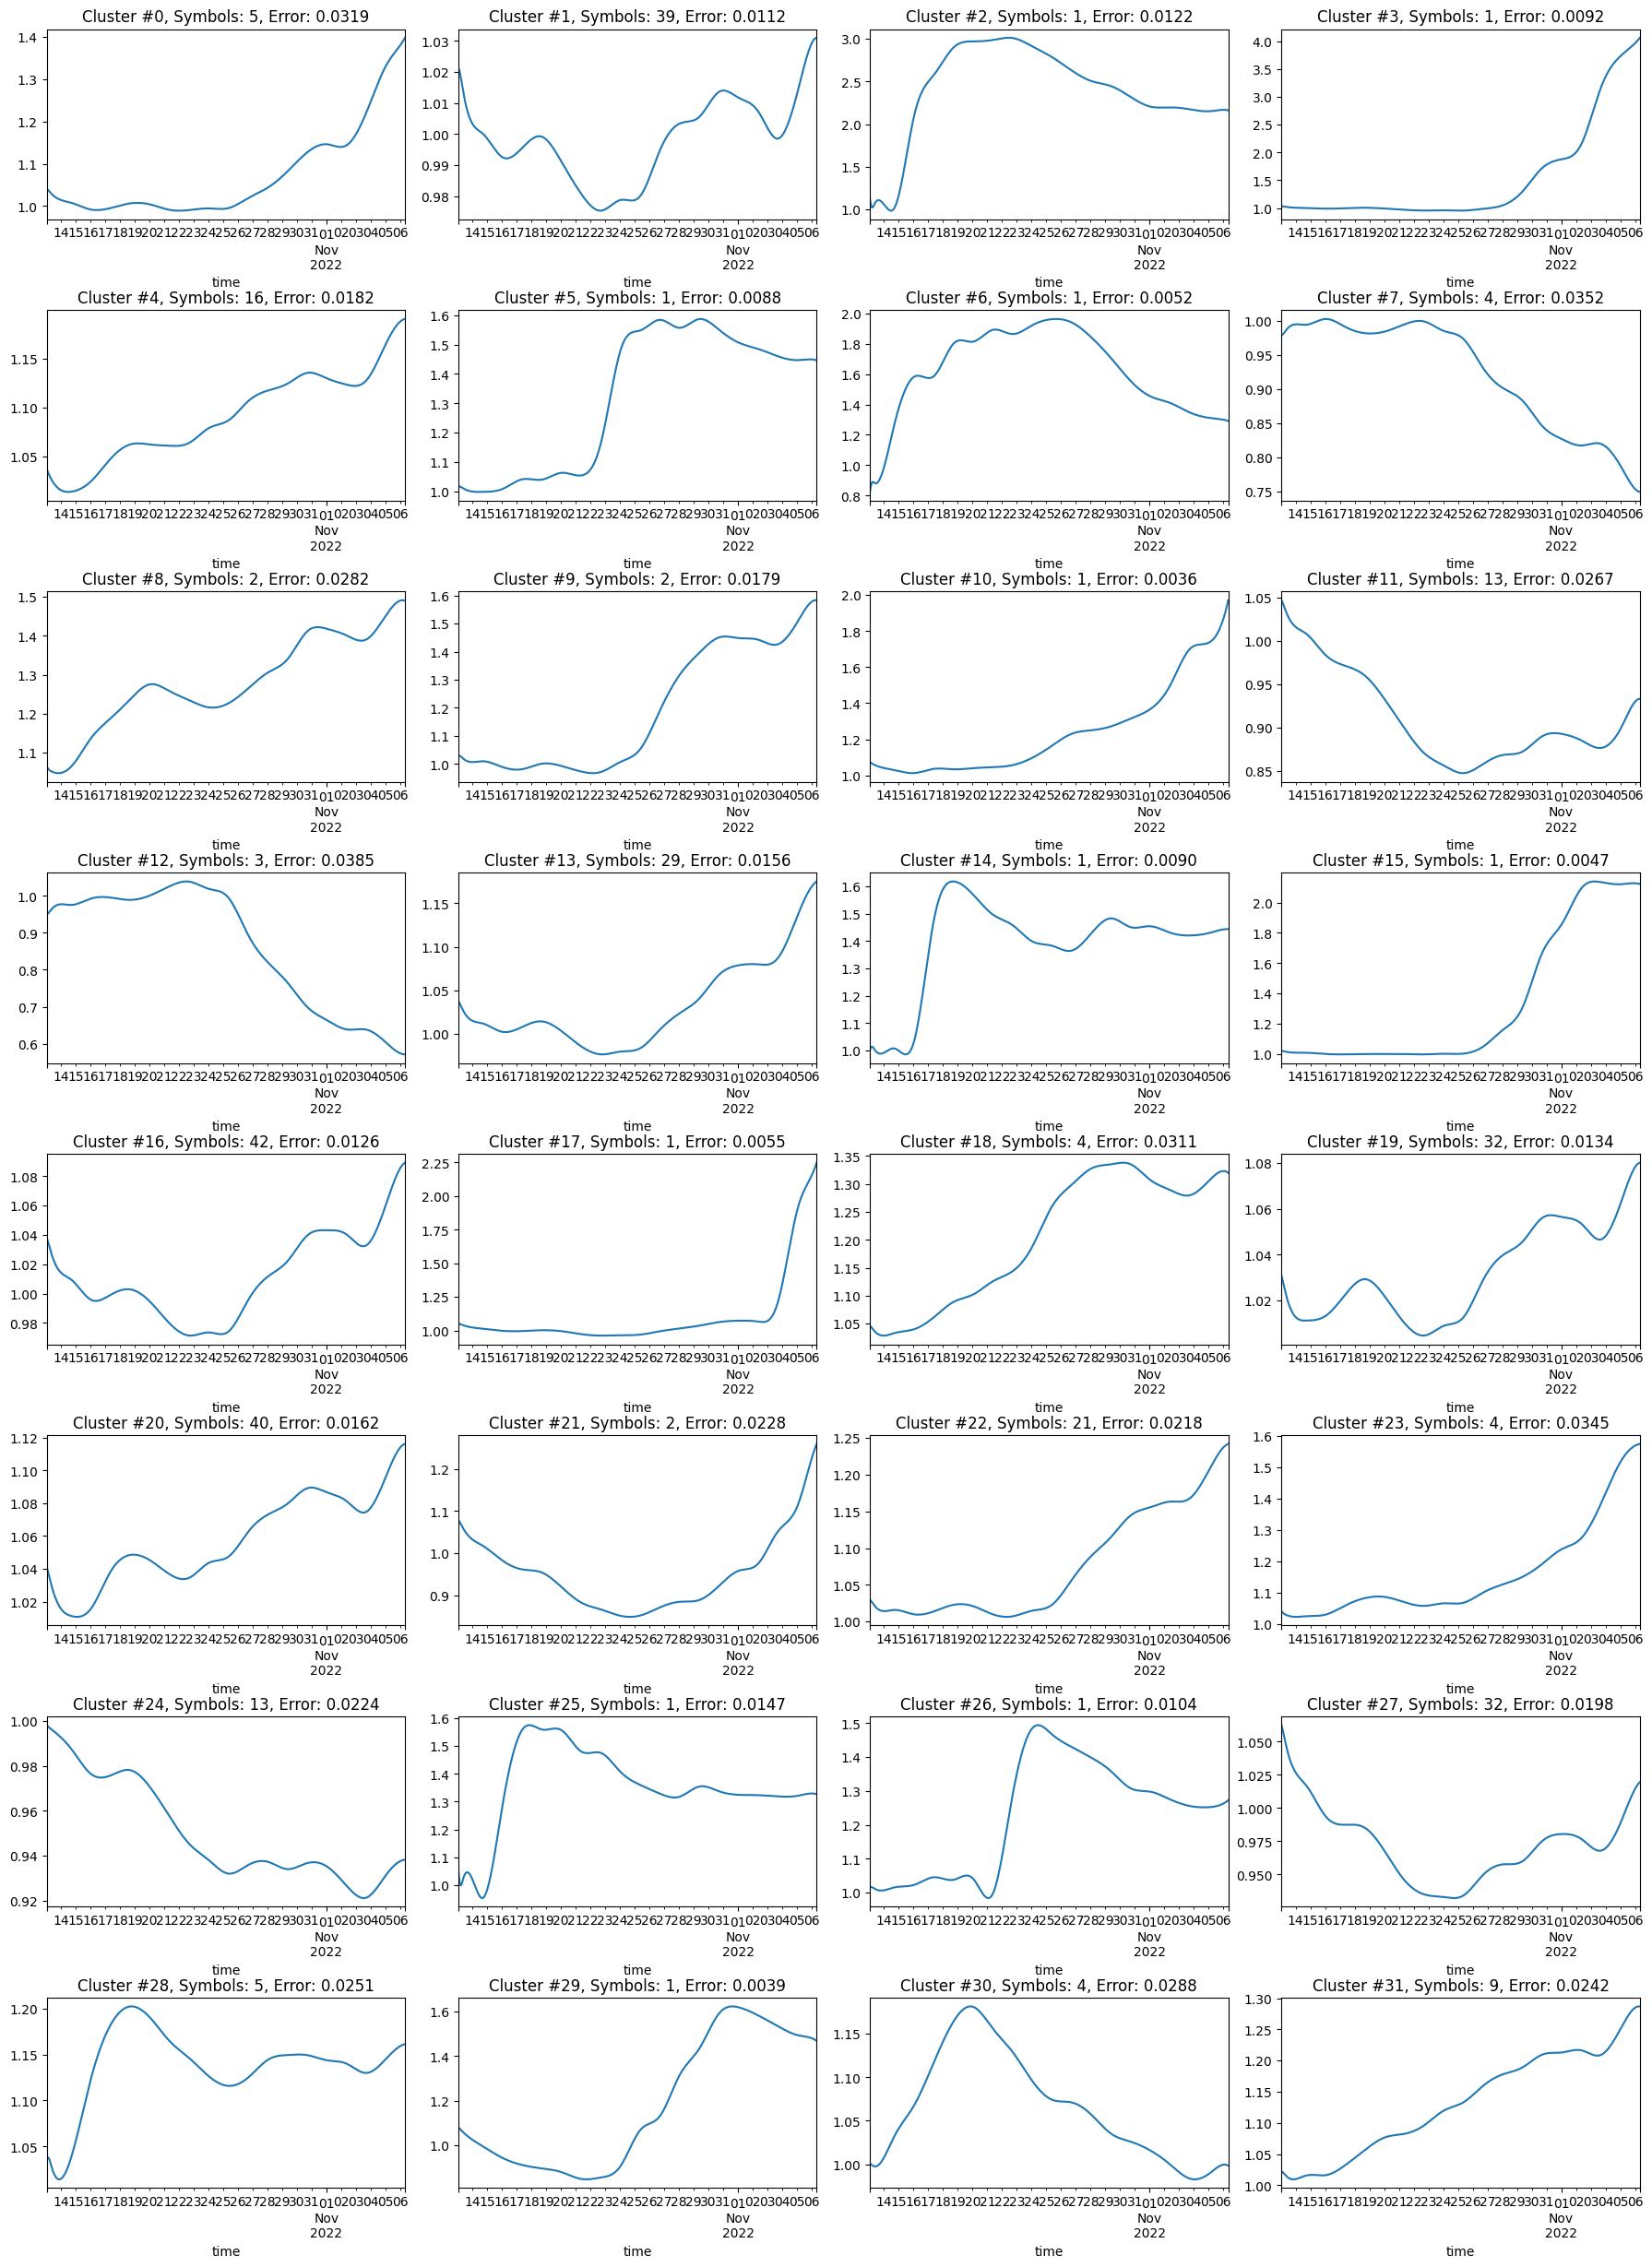

In [31]:
plt.rcParams['figure.figsize'] = [18, 24]
cluster_finder.plot_cluster_centers()

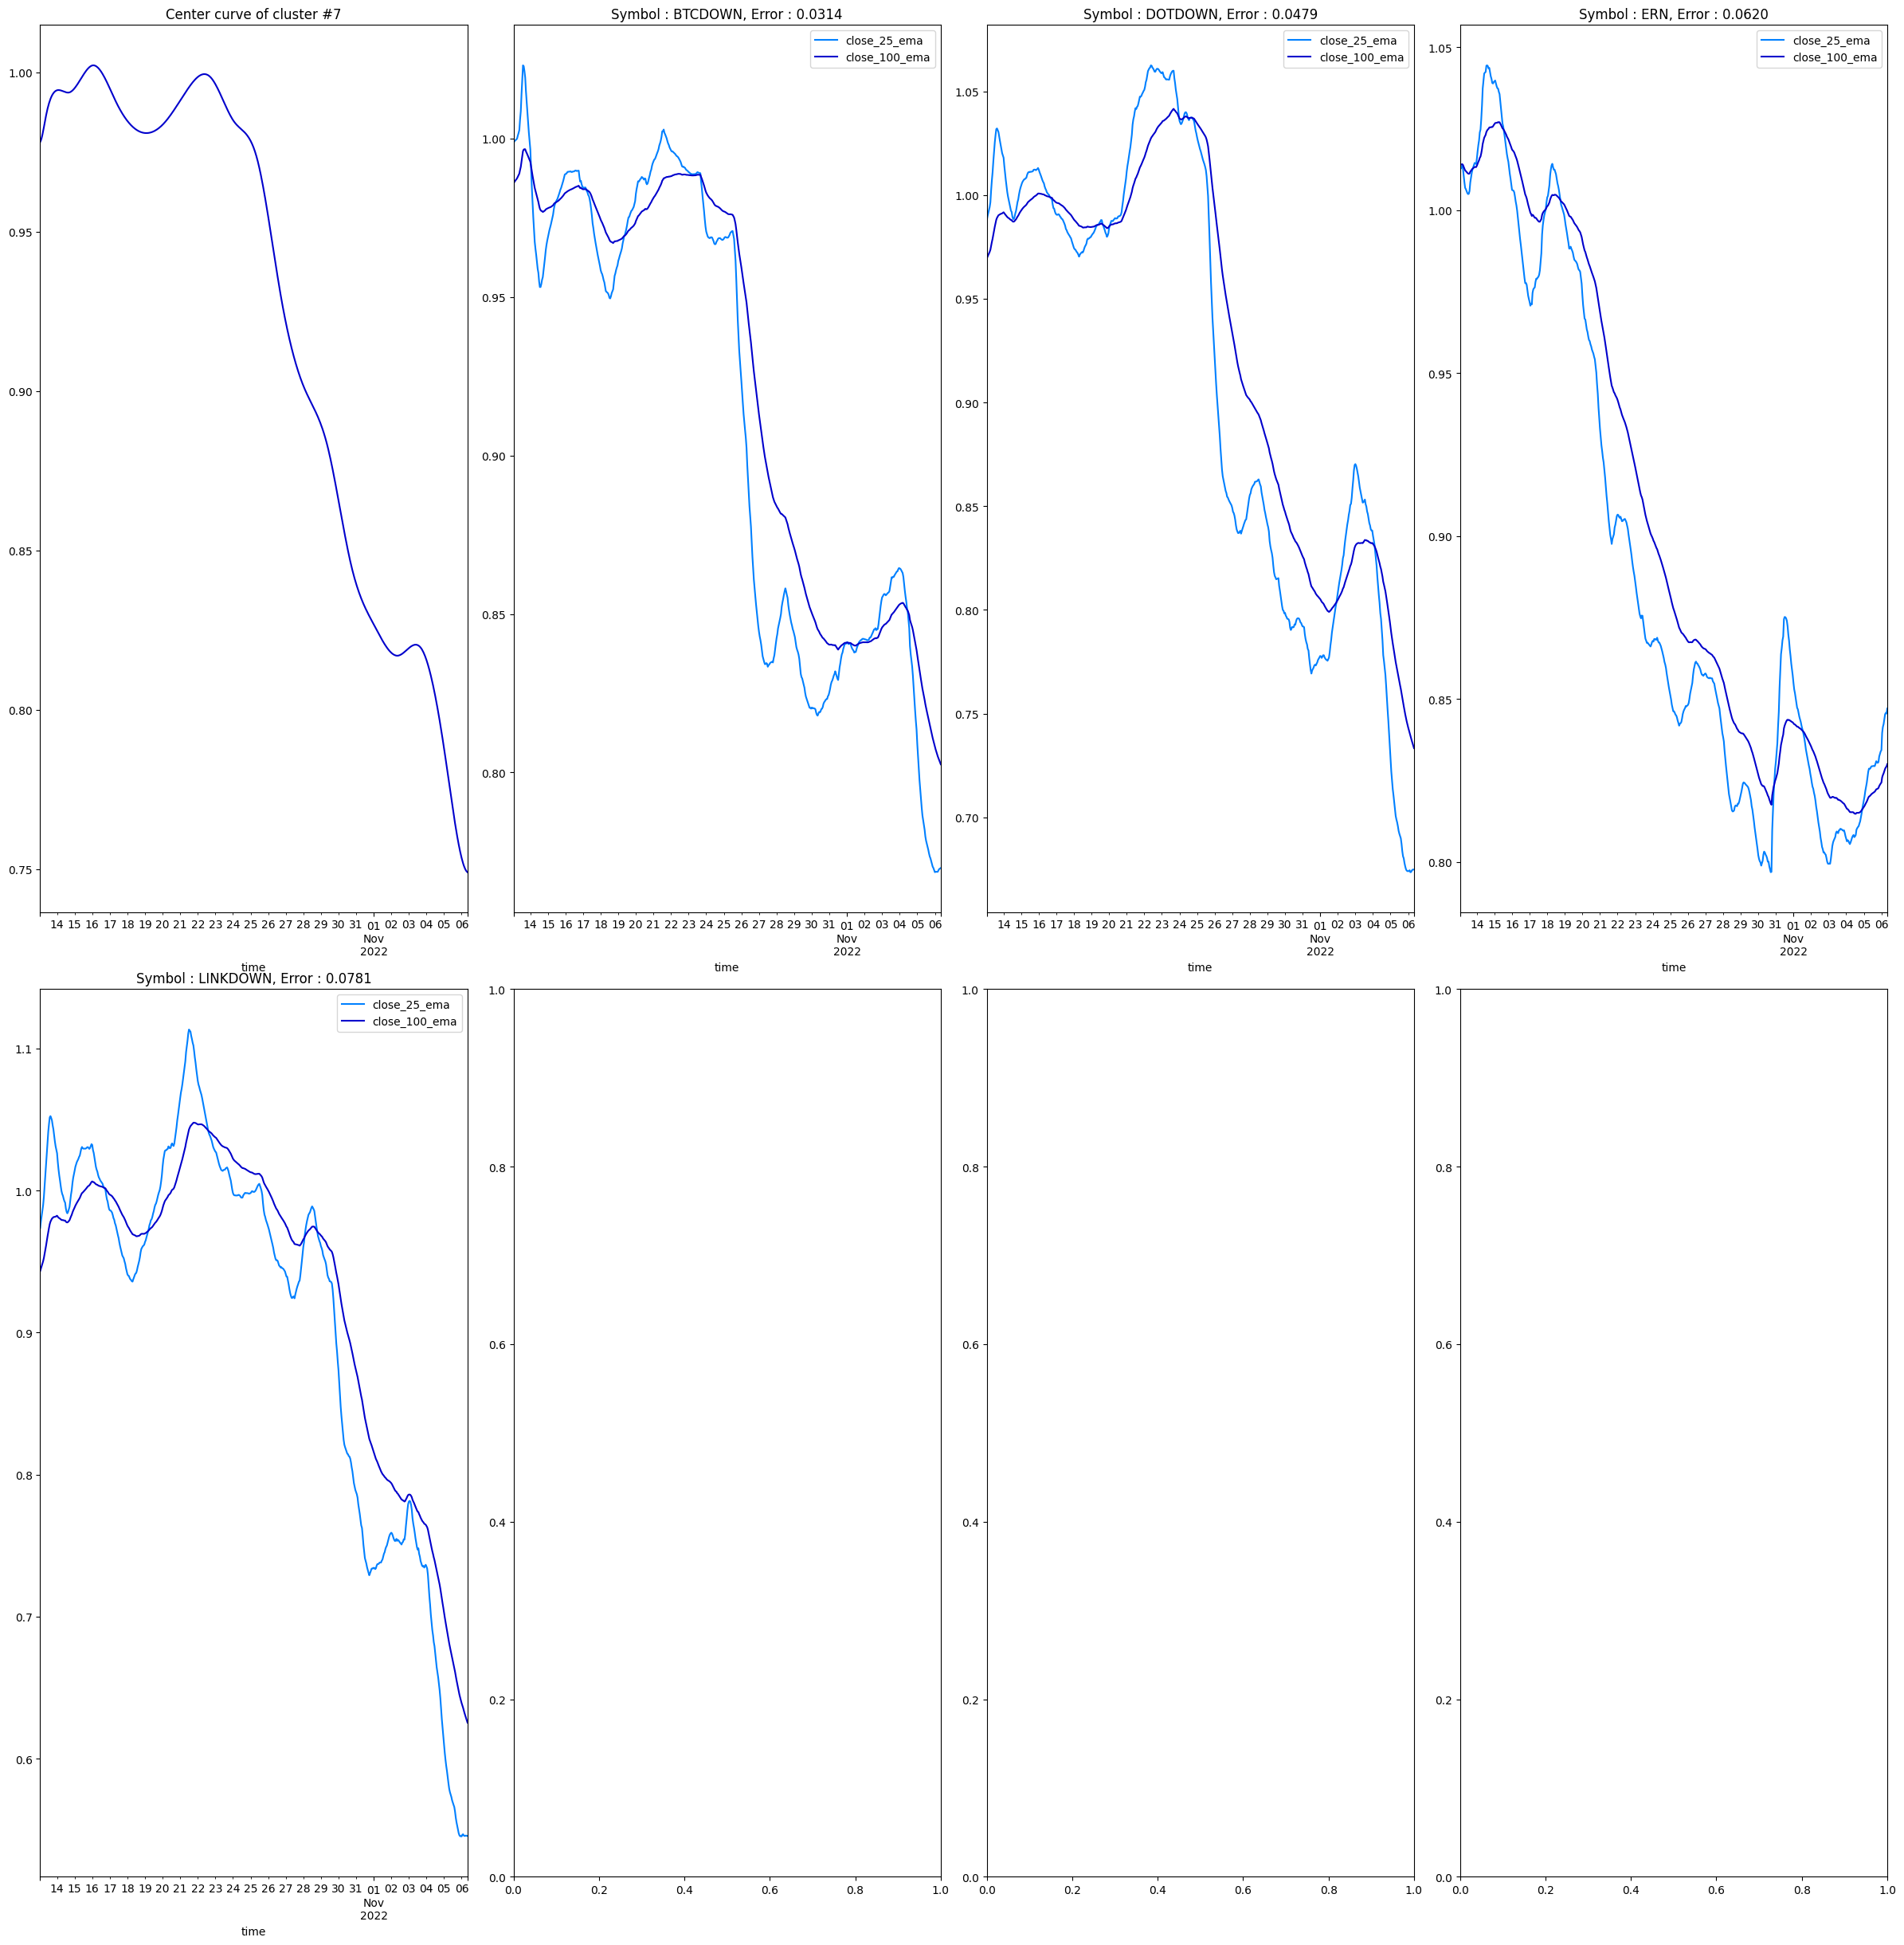

In [182]:
cluster_finder.clusters[7].plot(market_prices)

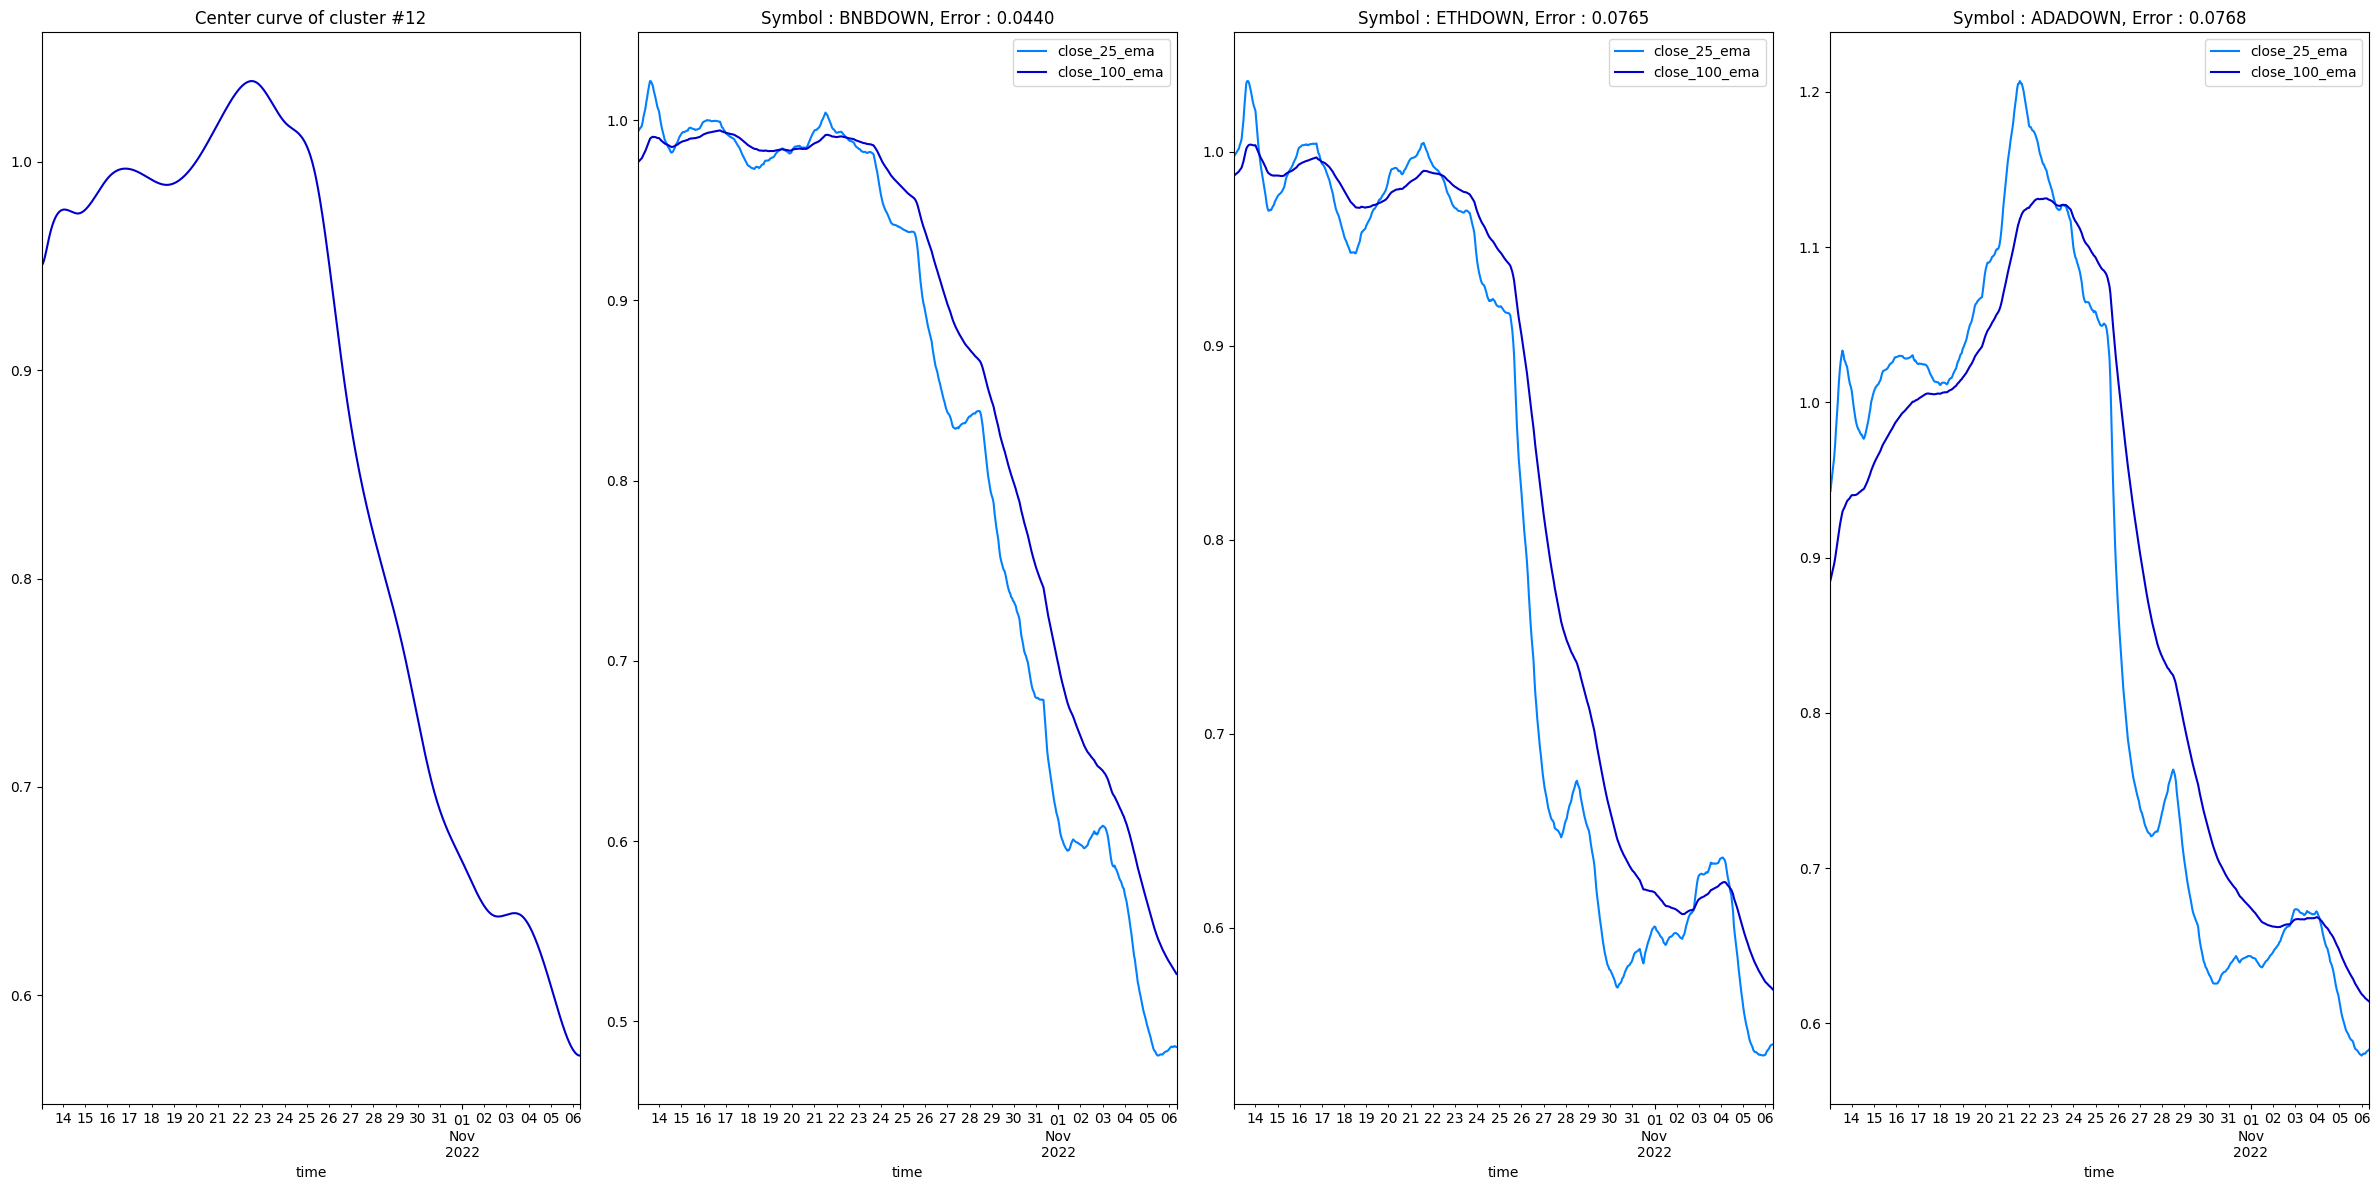

In [183]:
cluster_finder.clusters[12].plot(market_prices)

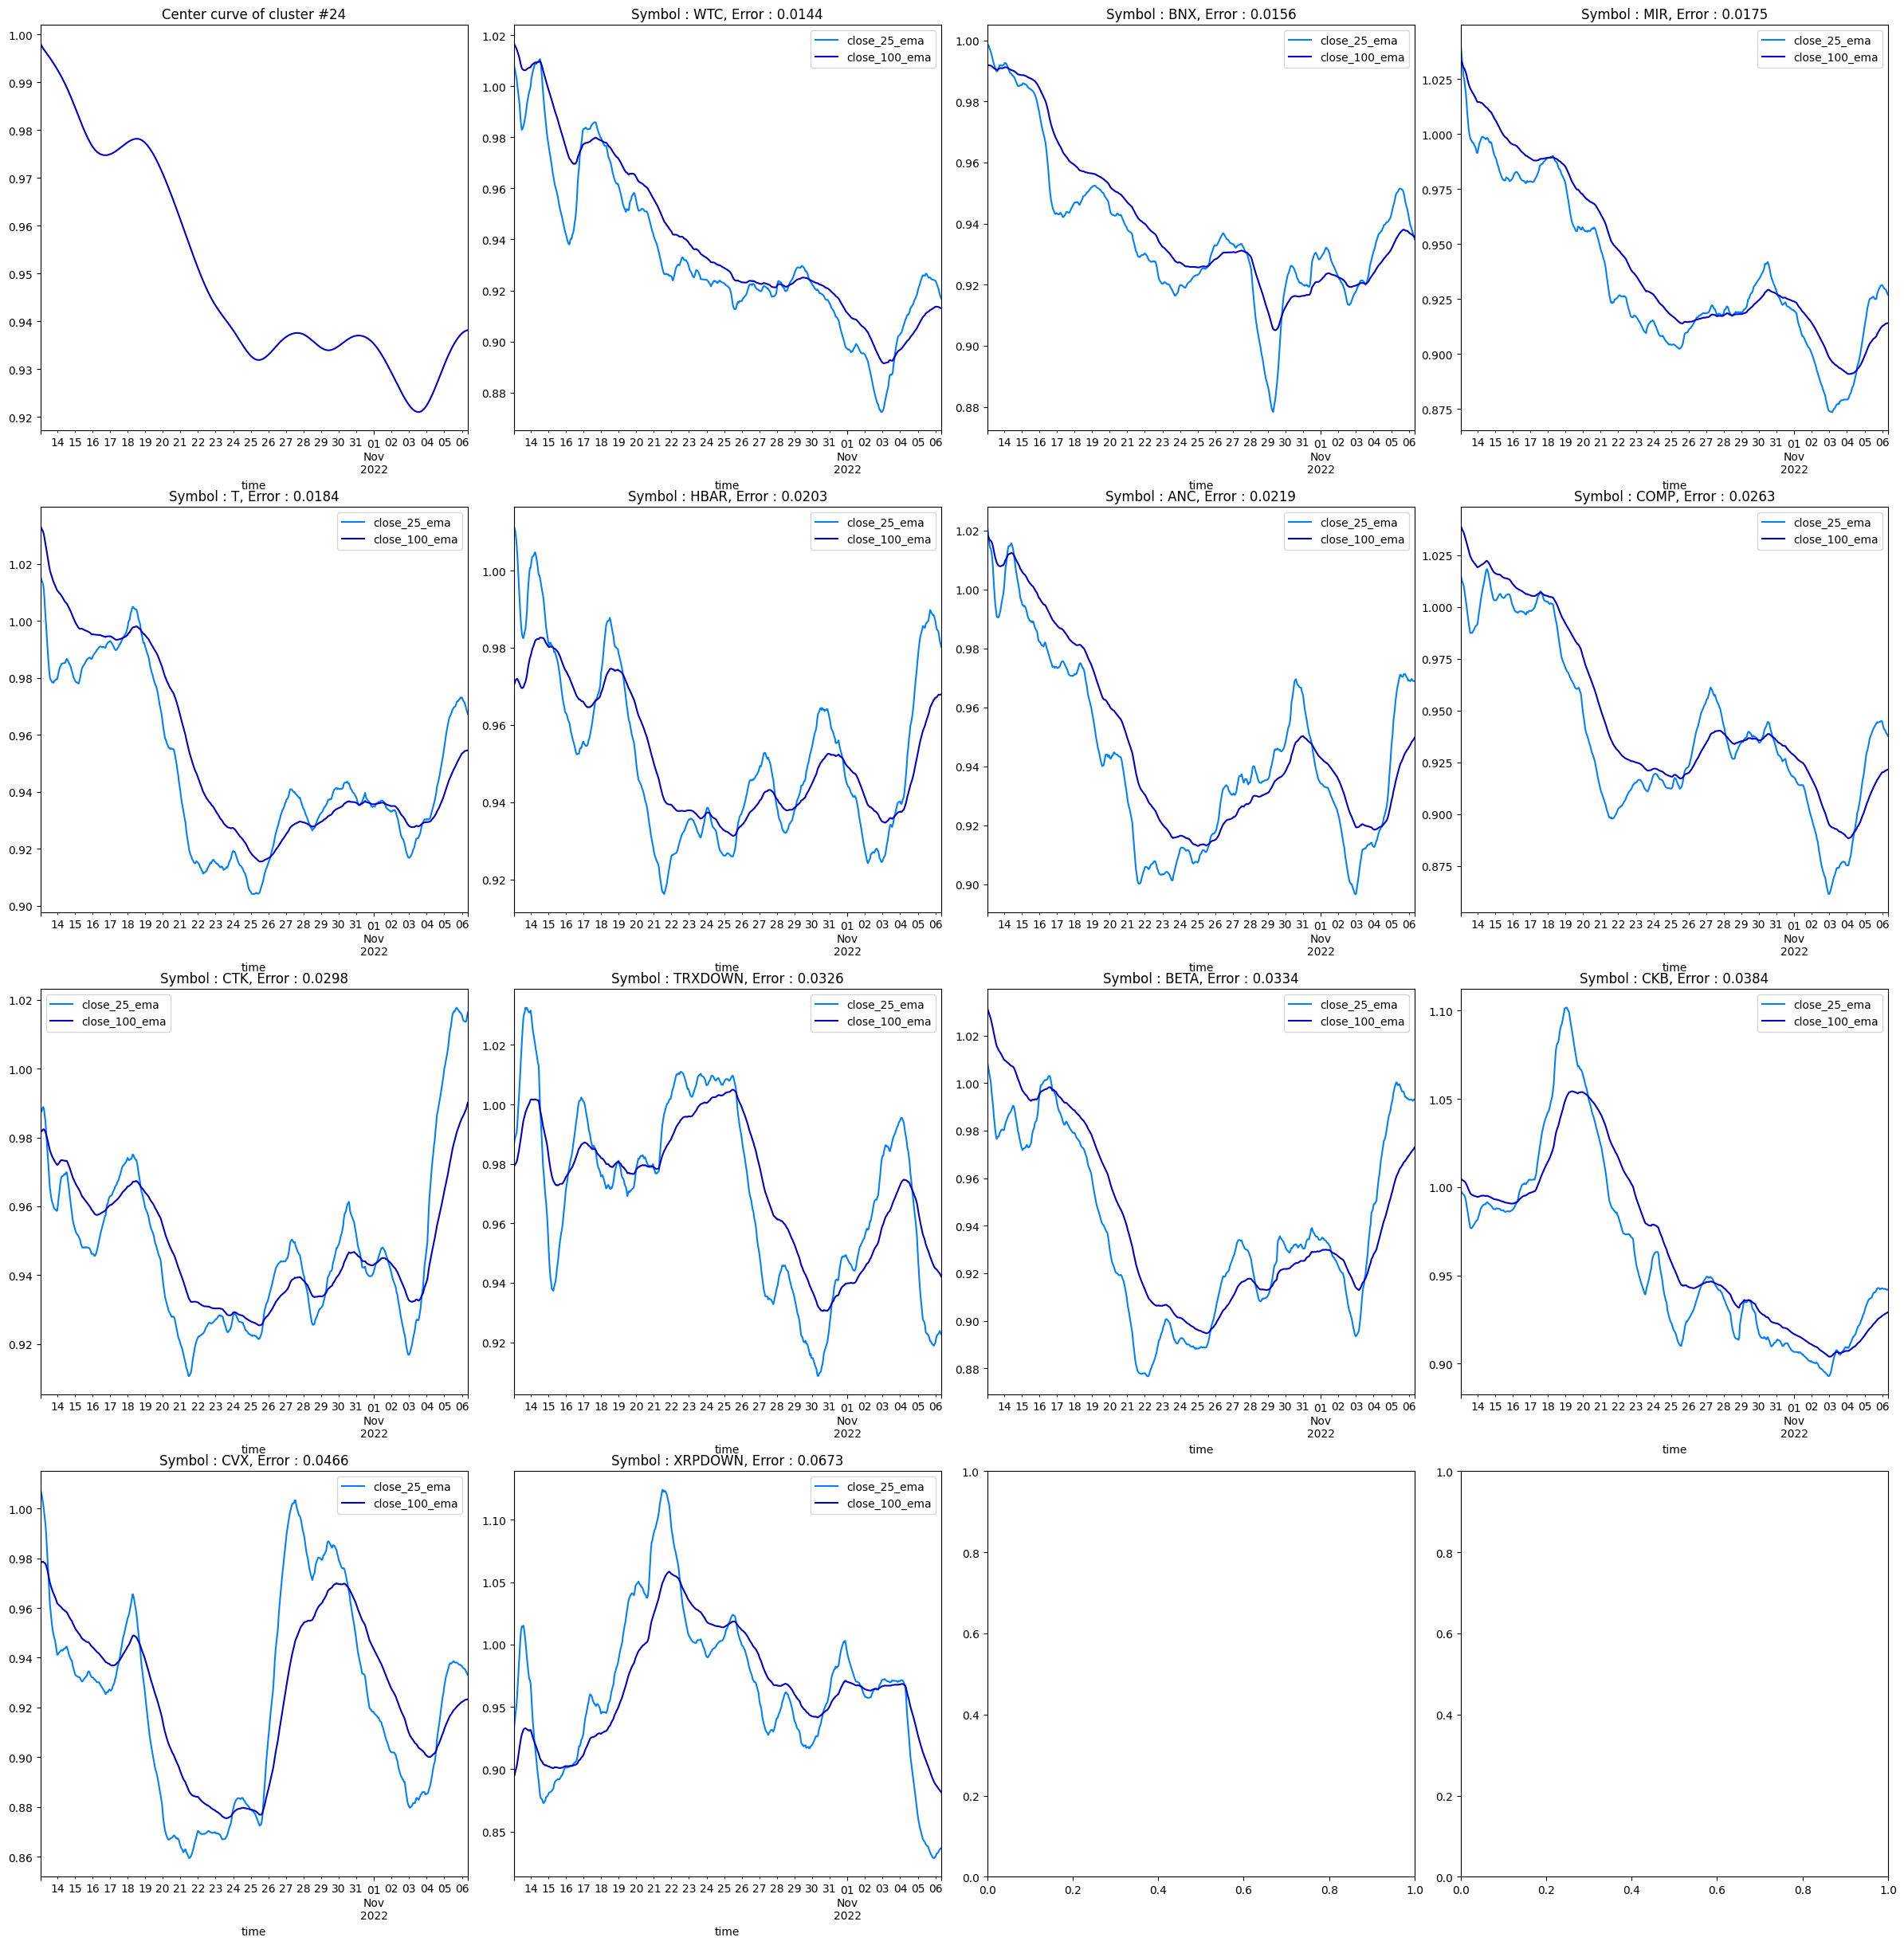

In [187]:
cluster_finder.clusters[24].plot(market_prices)

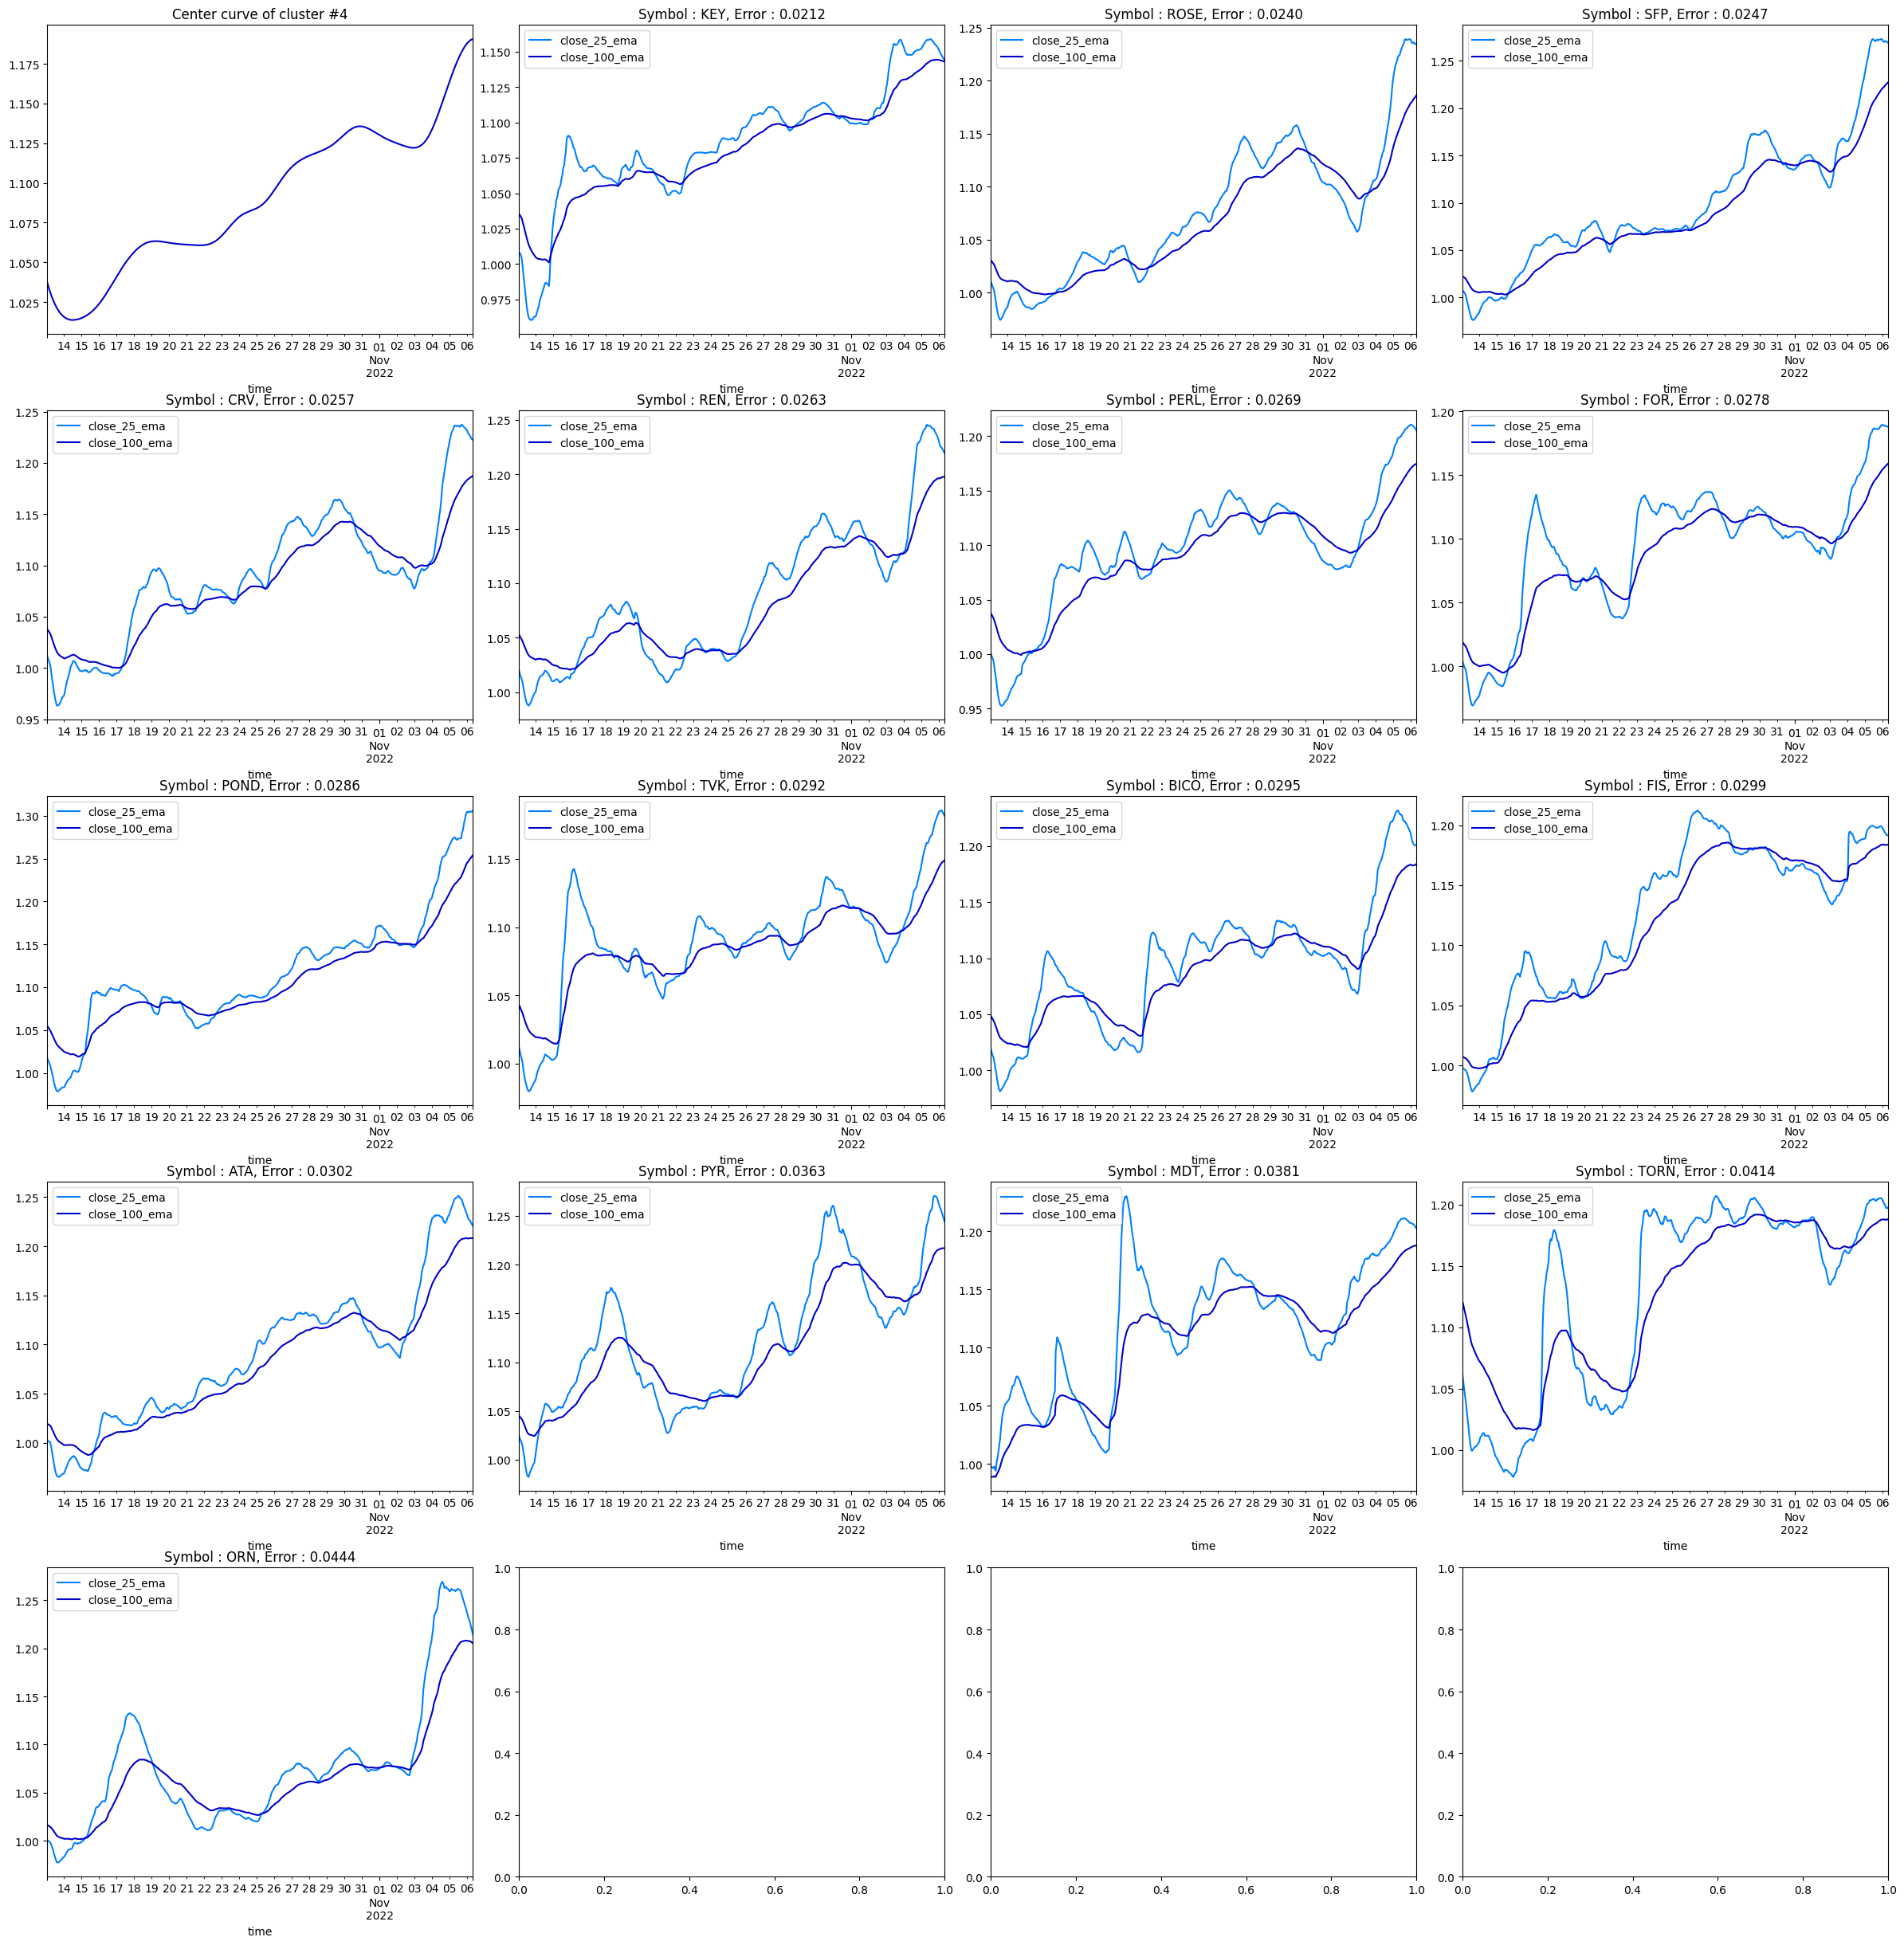

In [188]:
cluster_finder.clusters[4].plot(market_prices)

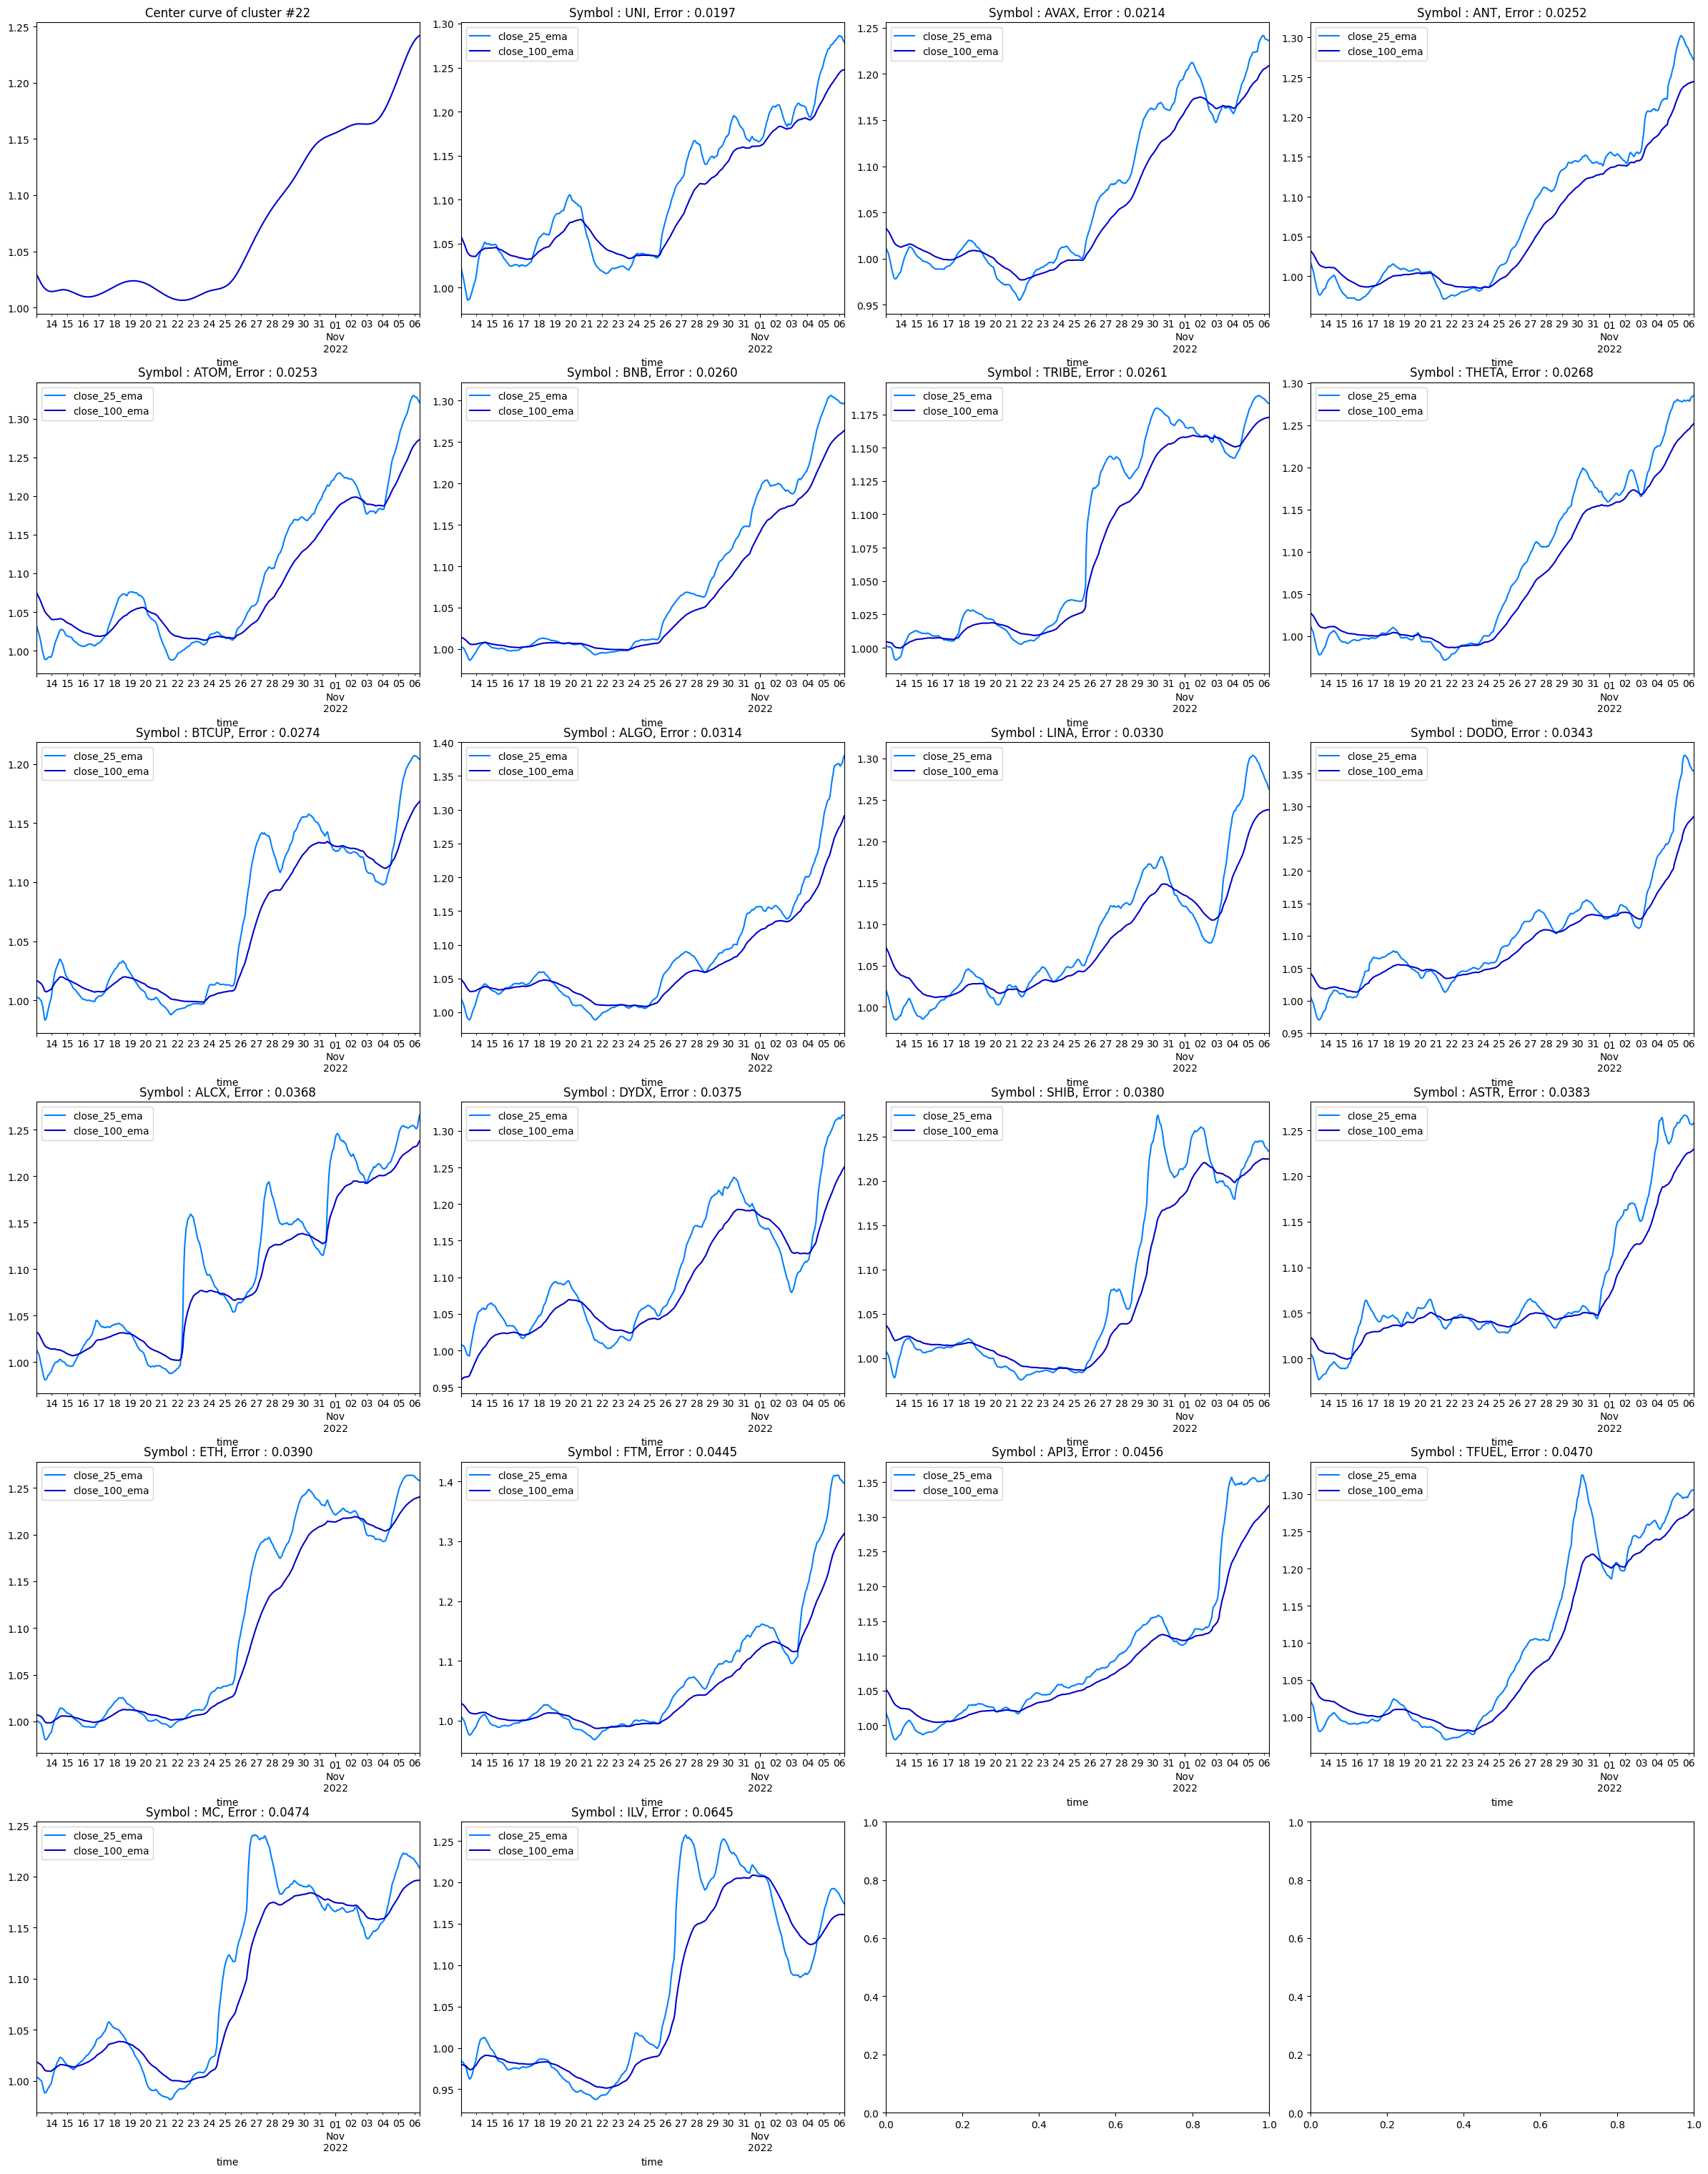

In [189]:
cluster_finder.clusters[22].plot(market_prices)

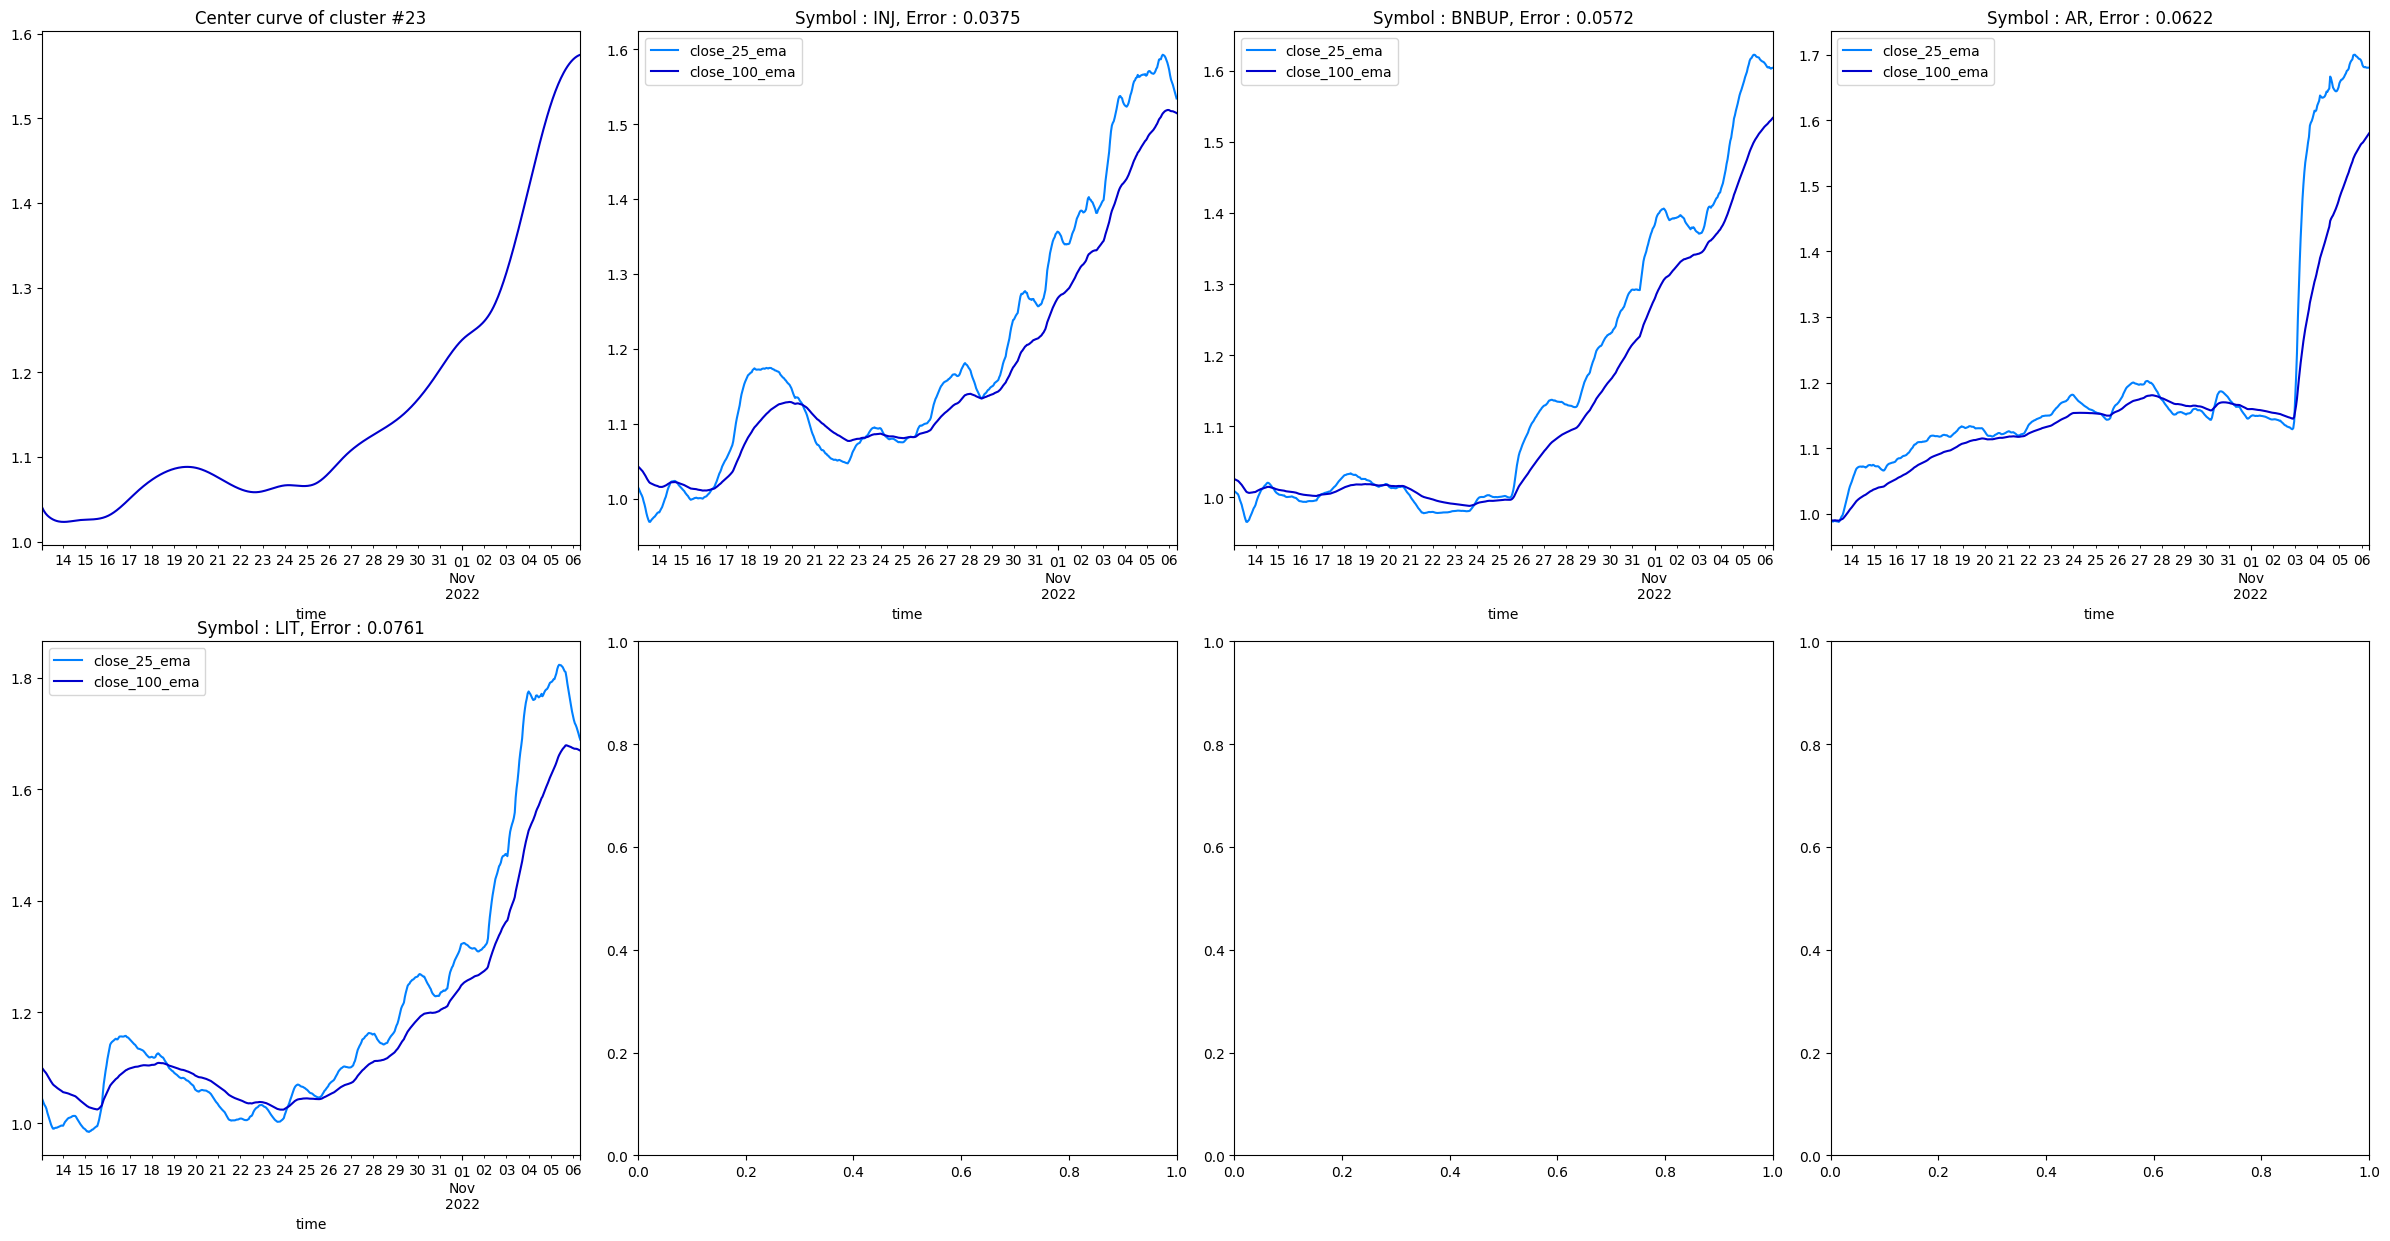

In [191]:
cluster_finder.clusters[23].plot(market_prices)

            error
count  332.000000
mean     0.032343
std      0.019085
min      0.008296
5%       0.014916
25%      0.019979
50%      0.026253
75%      0.037514
95%      0.074331
max      0.137932


<AxesSubplot: >

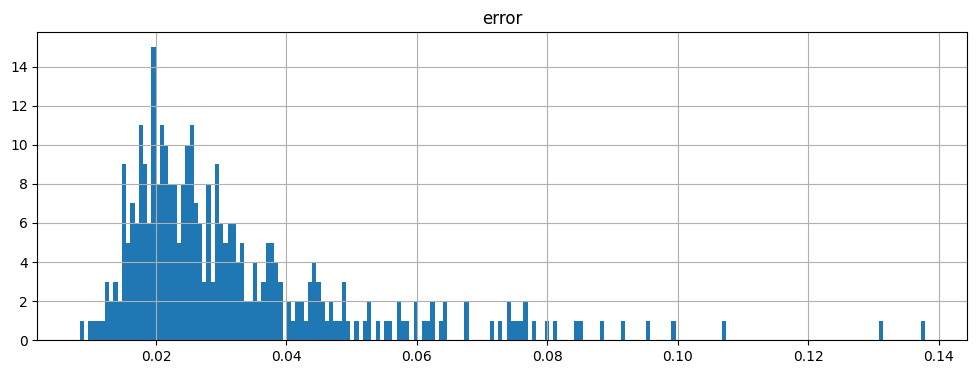

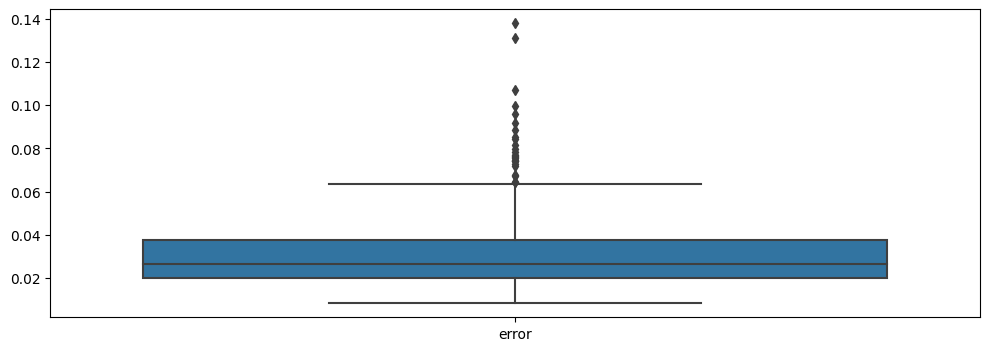

In [194]:
plt.rcParams['figure.figsize'] = [12, 4]

errors = pd.concat([cluster.errors for cluster in cluster_finder.clusters.values()])
print(errors.describe(percentiles=[0.05, 0.25, 0.5, 0.75, 0.95]))
errors.hist(bins=200)

<AxesSubplot: >

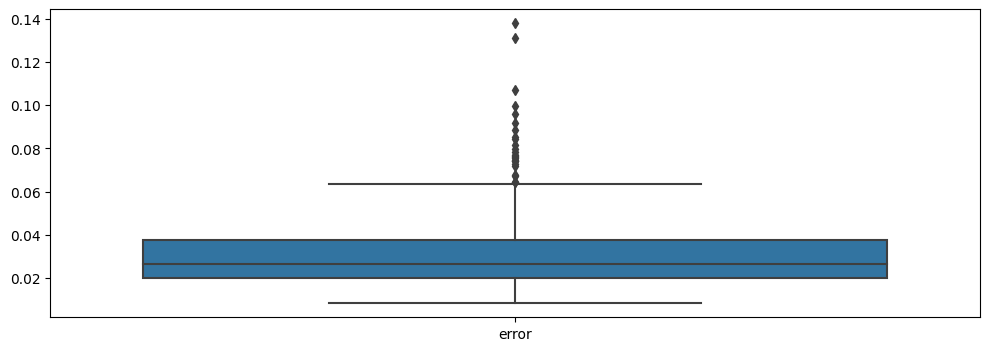

In [195]:
sns.boxplot(errors)

It took 9 of iterations to cluster into 12 group.Inertia is : 14.439408.
            error
count  332.000000
mean     0.038707
std      0.027584
min      0.009665
5%       0.015820
25%      0.021781
50%      0.029119
75%      0.044536
95%      0.093141
max      0.254100


array([[<AxesSubplot: title={'center': 'error'}>]], dtype=object)

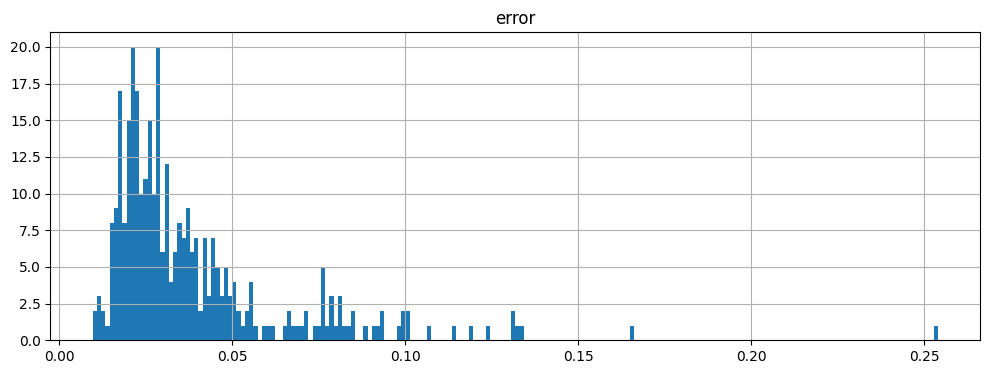

In [197]:
cluster_finder = ClusterFinder(12, curve_fitter)
cluster_finder.fit(market_prices)
plt.rcParams['figure.figsize'] = [12, 4]

errors = pd.concat([cluster.errors for cluster in cluster_finder.clusters.values()])
print(errors.describe(percentiles=[0.05, 0.25, 0.5, 0.75, 0.95]))
errors.hist(bins=200)

It took 5 of iterations to cluster into 12 group.Inertia is : 7.351078.
            error
count  315.000000
mean     0.031821
std      0.017501
min      0.009437
5%       0.014822
25%      0.020236
50%      0.025996
75%      0.037114
95%      0.074575
max      0.101963


<AxesSubplot: >

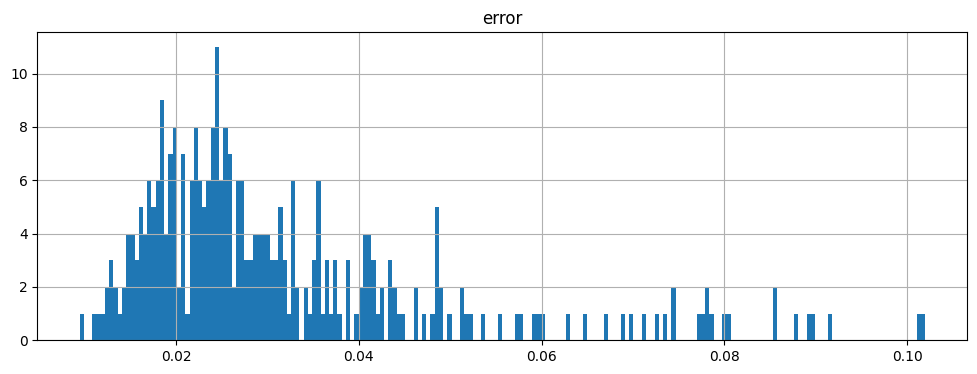

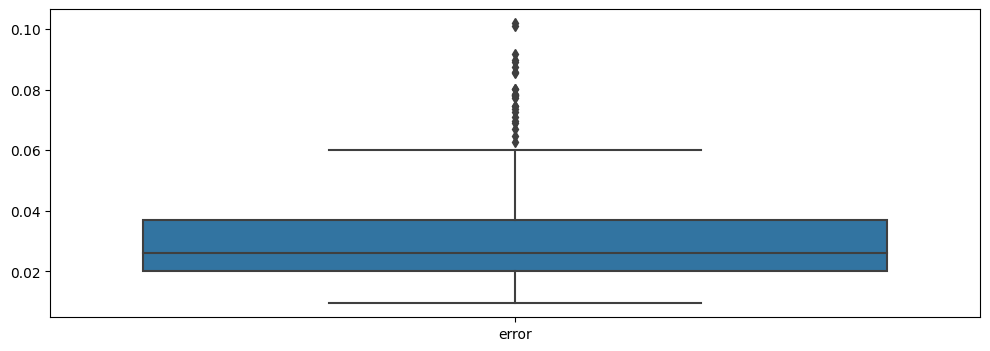

In [198]:
healthy = errors[errors.error < np.percentile(errors.error, 95)]
cluster_finder.fit(market_prices, healthy['symbol'])

errors = pd.concat([cluster.errors for cluster in cluster_finder.clusters.values()])
print(errors.describe(percentiles=[0.05, 0.25, 0.5, 0.75, 0.95]))
errors.hist(bins=200)

plt.figure()
sns.boxplot(errors)